<a href="https://colab.research.google.com/github/SLCFLAB/hd2025_time_series/blob/main/day2/Day2_SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 실습: Regression with ARIMA errors

## 1. 라이브러리 임포트

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')

## 2. 데이터 로드 (멜버른 일별 최저 기온)

In [2]:
from urllib.parse import urljoin
data_repo_url = "https://raw.githubusercontent.com/SLCFLAB/hd2025_time_series/refs/heads/main/datasets/"
df = pd.read_csv(urljoin(data_repo_url, "melbourne_temperature.csv"))
df.columns = ['Date', 'Temp']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [3]:
df

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8
...,...
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Temp    3650 non-null   float64
dtypes: float64(1)
memory usage: 57.0 KB


In [5]:
df.describe()

,Temp
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


In [6]:
# Create additional external variables (features)
# These are exogenous variables that might affect temperature
df['year'] = df.index.year
df['month'] = df.index.month
df['day_of_year'] = df.index.dayofyear
df['sin_year'] = np.sin(2 * np.pi * df['day_of_year'] / 365.25)
df['cos_year'] = np.cos(2 * np.pi * df['day_of_year'] / 365.25)

# Create trend variable
df['trend'] = np.arange(len(df))

# Add some lag features
df['temp_lag7'] = df['Temp'].shift(7)   # temperature 7 days ago
df['temp_lag30'] = df['Temp'].shift(30) # temperature 30 days ago

# Remove missing values
df = df.dropna()

External Variables (Regression Component):
   - Seasonal cycles: sin/cos of `day_of_year`
   - Trend: linear time trend
   - Lagged temperatures: 7 and 30 days ago

## EDA

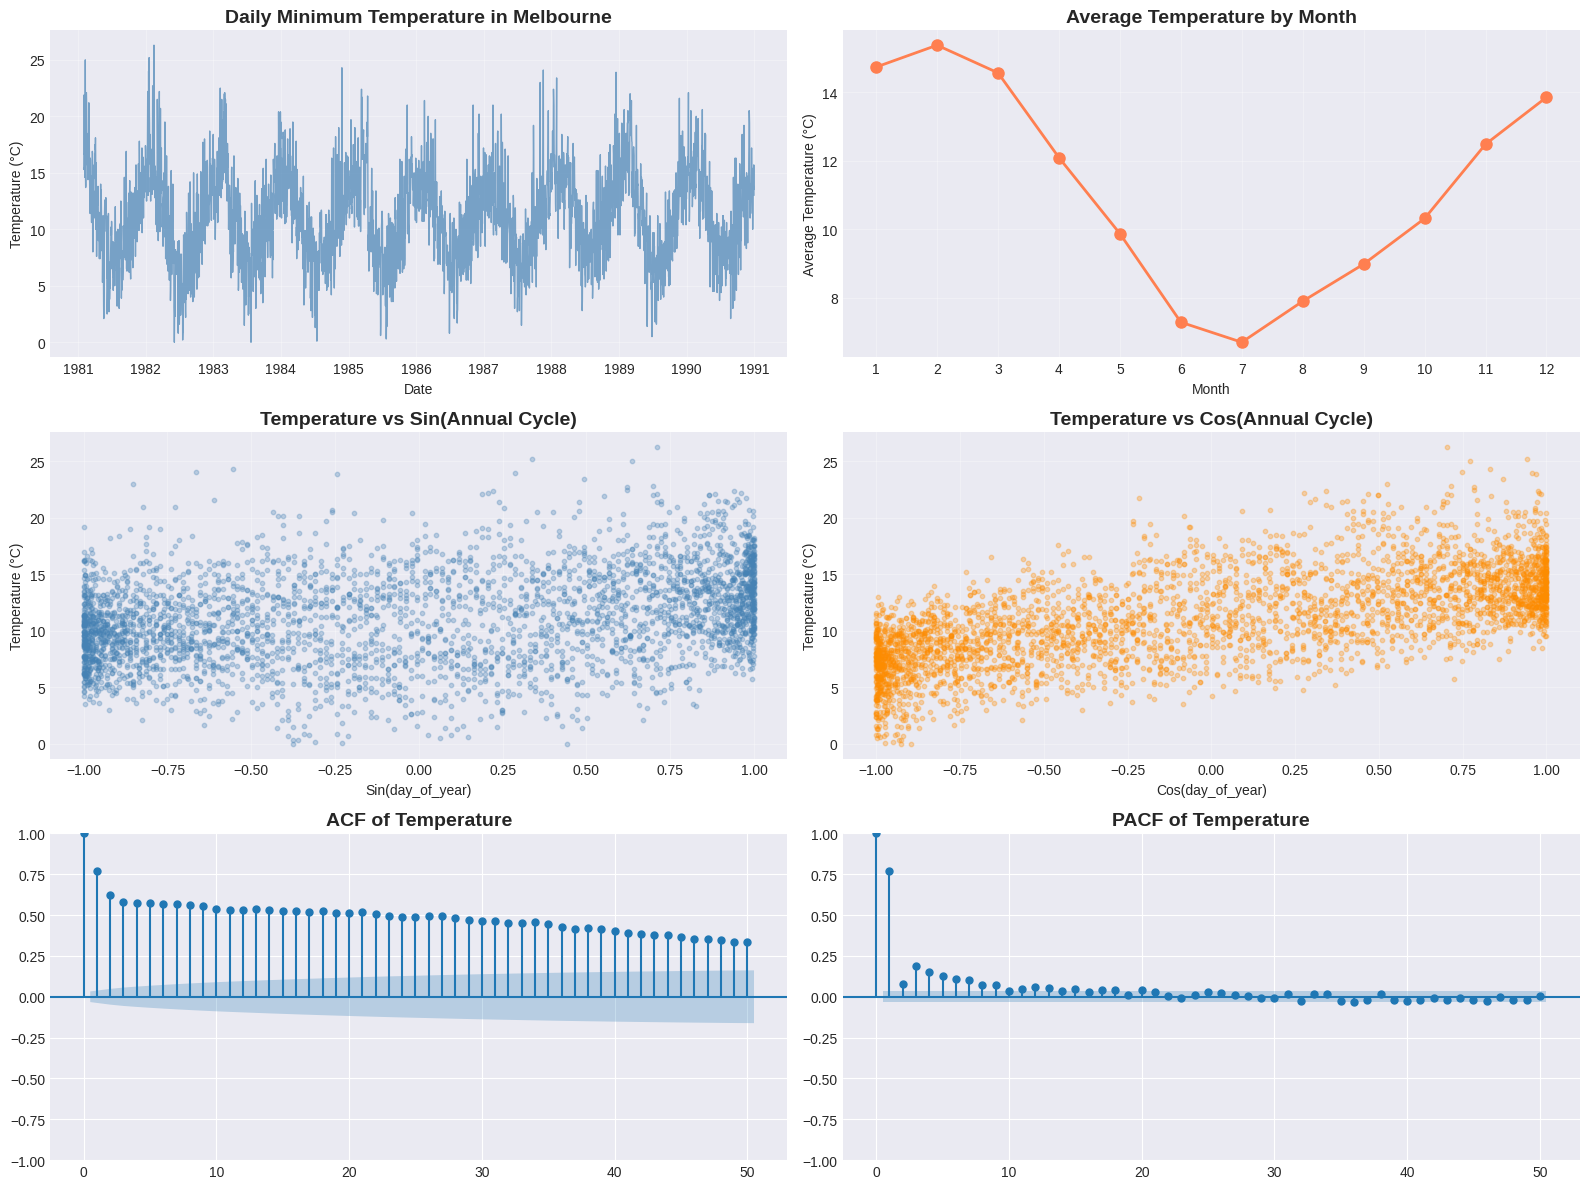

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Temperature time series
axes[0, 0].plot(df.index, df['Temp'], linewidth=1, alpha=0.7, color='steelblue')
axes[0, 0].set_title('Daily Minimum Temperature in Melbourne', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Temperature (°C)')
axes[0, 0].grid(True, alpha=0.3)

# Seasonal pattern
monthly_avg = df.groupby('month')['Temp'].mean()
axes[0, 1].plot(monthly_avg.index, monthly_avg.values, marker='o', linewidth=2, markersize=8, color='coral')
axes[0, 1].set_title('Average Temperature by Month', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Average Temperature (°C)')
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].grid(True, alpha=0.3)

# Correlation with fourier terms
axes[1, 0].scatter(df['sin_year'], df['Temp'], alpha=0.3, s=10, color='steelblue')
axes[1, 0].set_title('Temperature vs Sin(Annual Cycle)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Sin(day_of_year)')
axes[1, 0].set_ylabel('Temperature (°C)')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].scatter(df['cos_year'], df['Temp'], alpha=0.3, s=10, color='darkorange')
axes[1, 1].set_title('Temperature vs Cos(Annual Cycle)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Cos(day_of_year)')
axes[1, 1].set_ylabel('Temperature (°C)')
axes[1, 1].grid(True, alpha=0.3)

# ACF and PACF
plot_acf(df['Temp'], lags=50, ax=axes[2, 0])
axes[2, 0].set_title('ACF of Temperature', fontsize=14, fontweight='bold')

plot_pacf(df['Temp'], lags=50, ax=axes[2, 1])
axes[2, 1].set_title('PACF of Temperature', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [8]:
# Correlation matrix
print("\n" + "=" * 60)
print("Correlation Matrix")
print("=" * 60)
correlation_vars = ['Temp', 'sin_year', 'cos_year', 'trend', 'temp_lag7', 'temp_lag30']
corr_matrix = df[correlation_vars].corr()
print(corr_matrix['Temp'].sort_values(ascending=False))


Correlation Matrix
Temp          1.000000
cos_year      0.655048
temp_lag7     0.571033
temp_lag30    0.482528
sin_year      0.315856
trend         0.036230
Name: Temp, dtype: float64


## 4. Train/Test 분리

In [9]:
train_size = int(len(df) * 0.7)
train = df.iloc[:train_size].copy()
test = df.iloc[train_size:].copy()

print(f"\n{'='*60}")
print("Train/Test Split")
print("=" * 60)
print(f"Train: {len(train)} observations ({train.index[0]} to {train.index[-1]})")
print(f"Test:  {len(test)} observations ({test.index[0]} to {test.index[-1]})")


Train/Test Split
Train: 2534 observations (1981-01-31 00:00:00 to 1988-01-09 00:00:00)
Test:  1086 observations (1988-01-10 00:00:00 to 1990-12-31 00:00:00)


## 5. Model 1: Simple Linear Regression (Baseline)

In [10]:
# Prepare features
feature_cols = ['sin_year', 'cos_year', 'trend', 'temp_lag7', 'temp_lag30']
X_train = train[feature_cols]
y_train = train['Temp']
X_test = test[feature_cols]
y_test = test['Temp']

In [11]:
# Fit linear regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [12]:
# Predictions
lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

In [13]:
# Calculate residuals
train['lr_residuals'] = y_train - lr_train_pred
test['lr_residuals'] = y_test - lr_test_pred

# Metrics
lr_train_mae = mean_absolute_error(y_train, lr_train_pred)
lr_train_rmse = root_mean_squared_error(y_train, lr_train_pred)
lr_test_mae = mean_absolute_error(y_test, lr_test_pred)
lr_test_rmse = root_mean_squared_error(y_test, lr_test_pred)

In [14]:
print(f"\n{'='*60}")
print("Model 1: Linear Regression (Baseline)")
print("=" * 60)
print(f"Train MAE:  {lr_train_mae:.3f}°C")
print(f"Train RMSE: {lr_train_rmse:.3f}°C")
print(f"Test MAE:   {lr_test_mae:.3f}°C")
print(f"Test RMSE:  {lr_test_rmse:.3f}°C")


Model 1: Linear Regression (Baseline)
Train MAE:  2.217°C
Train RMSE: 2.798°C
Test MAE:   2.133°C
Test RMSE:  2.714°C


## 6. 잔차 분석 (Linear Regression의 문제점 확인)

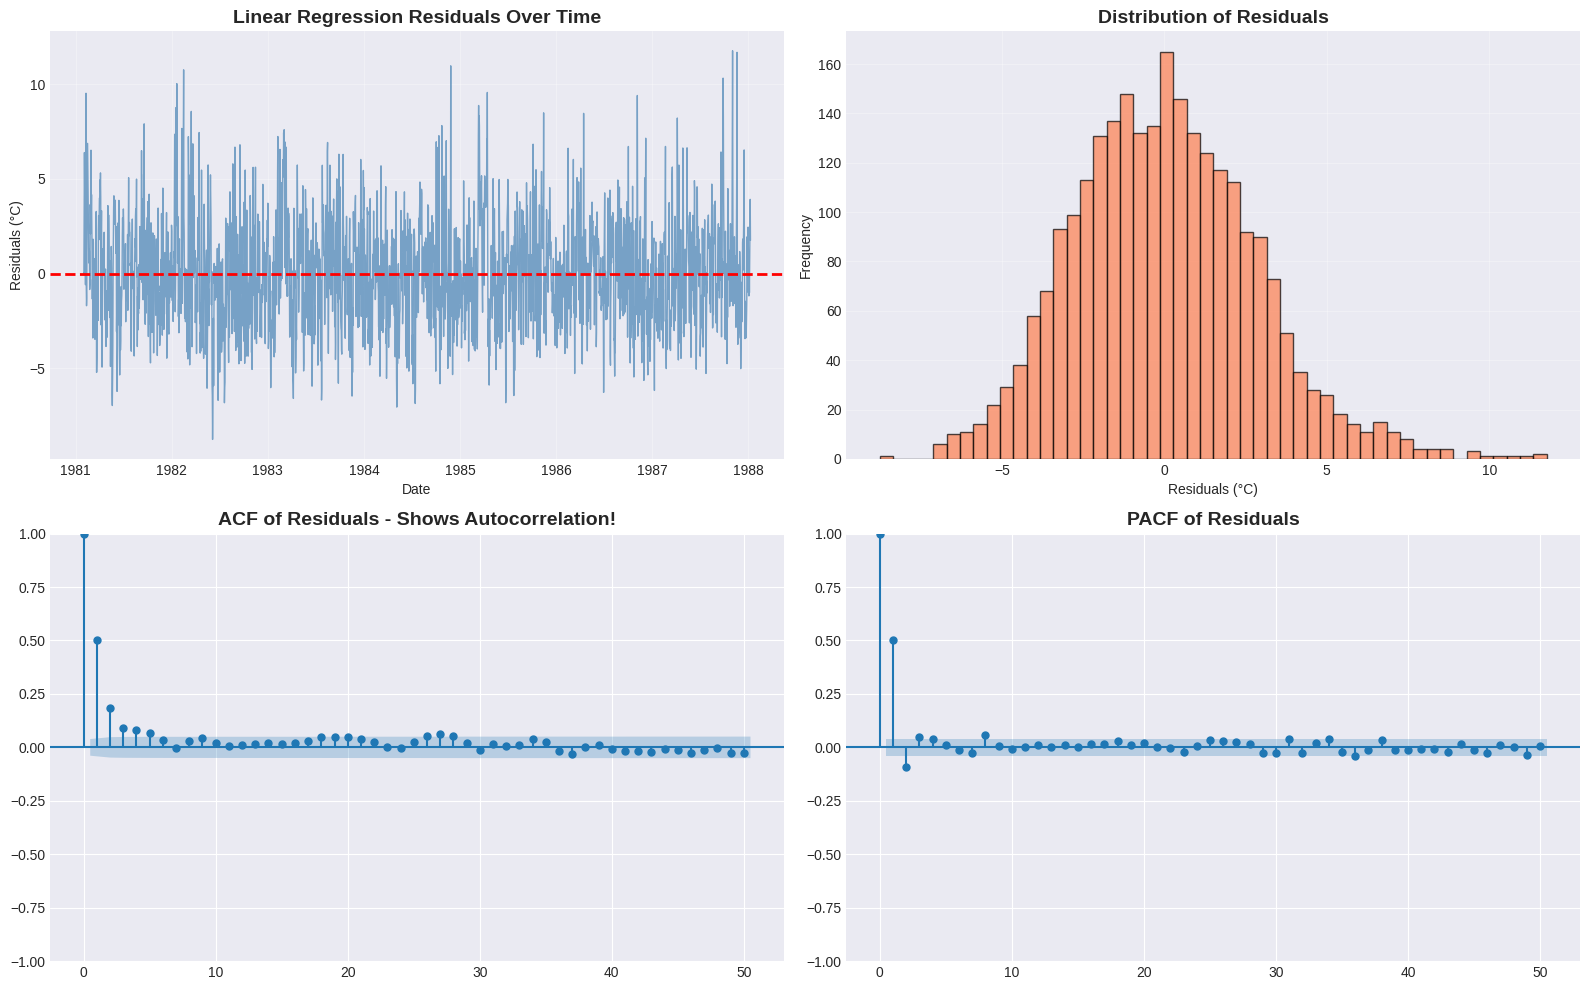

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Residuals over time
axes[0, 0].plot(train.index, train['lr_residuals'], linewidth=1, alpha=0.7, color='steelblue')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('Linear Regression Residuals Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Residuals (°C)')
axes[0, 0].grid(True, alpha=0.3)

# Residuals histogram
axes[0, 1].hist(train['lr_residuals'], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Residuals (°C)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# ACF of residuals - KEY INSIGHT!
plot_acf(train['lr_residuals'], lags=50, ax=axes[1, 0])
axes[1, 0].set_title('ACF of Residuals - Shows Autocorrelation!', fontsize=14, fontweight='bold')

# PACF of residuals
plot_pacf(train['lr_residuals'], lags=50, ax=axes[1, 1])
axes[1, 1].set_title('PACF of Residuals', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

In [16]:
# ADF test on residuals
adf_result = adfuller(train['lr_residuals'].dropna())
print(f"\n{'='*60}")
print("Residual Analysis: Linear Regression")
print("=" * 60)
print(f"ADF Statistic: {adf_result[0]:.6f}")
print(f"p-value: {adf_result[1]:.6f}")


Residual Analysis: Linear Regression
ADF Statistic: -15.163421
p-value: 0.000000


**Key Finding**   

The residuals show significant autocorrelation in ACF plot!      
This violates the independence assumption of linear regression.     
→ **We need to model the error structure with ARIMA!**

## 7. Model 2: Regression with ARIMA Errors


Goal: Select Best model among candidates

In [17]:
# Prepare exogenous variables
exog_train = train[feature_cols]
exog_test = test[feature_cols]

In [18]:
# Candidate models based on residual patterns
candidates = [
    ((1, 0, 1), (0, 0, 0, 0), "ARMA(1,1) - Most parsimonious"),
    ((2, 0, 1), (0, 0, 0, 0), "ARMA(2,1) - More flexible"),
    ((1, 0, 1), (1, 0, 0, 7), "SARIMA(1,0,1)(1,0,0,7) - Weekly seasonality"),
    ((2, 0, 0), (0, 0, 0, 0), "AR(2) - Simple alternative"),
    ((1, 0, 7), (0, 0, 0, 0), "ARMA(1,7) - Long-term pattern")
]

In [19]:
results = []
best_aic = np.inf
best_model = None
best_order = None
best_name = None

print("\nFitting candidate models...")
print("-" * 60)

for order, seasonal_order, name in candidates:
    try:
        model = SARIMAX(
            train['Temp'],
            exog=exog_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )

        fitted = model.fit(disp=False, maxiter=200)

        # Get predictions
        train_pred = fitted.fittedvalues
        test_pred = fitted.forecast(steps=len(test), exog=exog_test)

        # Calculate metrics
        train_mae = mean_absolute_error(train['Temp'], train_pred)
        train_rmse = root_mean_squared_error(train['Temp'], train_pred)
        test_mae = mean_absolute_error(test['Temp'], test_pred)
        test_rmse = root_mean_squared_error(test['Temp'], test_pred)

        # Store results
        results.append({
            'Model': name,
            'Order': str(order),
            'AIC': fitted.aic,
            'BIC': fitted.bic,
            'Train_MAE': train_mae,
            'Train_RMSE': train_rmse,
            'Test_MAE': test_mae,
            'Test_RMSE': test_rmse,
            'fitted_model': fitted,
            'test_pred': test_pred
        })

        print(f"✓ {name:40s} | AIC: {fitted.aic:8.2f} | Test MAE: {test_mae:.3f}°C")

        if fitted.aic < best_aic:
            best_aic = fitted.aic
            best_model = fitted
            best_order = order
            best_name = name

    except Exception as e:
        print(f"✗ {name:40s} | Failed: {str(e)[:30]}")
        continue


Fitting candidate models...
------------------------------------------------------------
✓ ARMA(1,1) - Most parsimonious            | AIC: 12409.98 | Test MAE: 3.173°C
✓ ARMA(2,1) - More flexible                | AIC: 11686.93 | Test MAE: 2.072°C
✓ SARIMA(1,0,1)(1,0,0,7) - Weekly seasonality | AIC: 12261.12 | Test MAE: 2.435°C
✓ AR(2) - Simple alternative               | AIC: 12201.14 | Test MAE: 7.805°C
✓ ARMA(1,7) - Long-term pattern            | AIC: 11810.34 | Test MAE: 2.693°C


In [20]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.drop(columns=['fitted_model', 'test_pred'])

In [21]:
print("\n" + "="*60)
print("Model Comparison Results")
print("="*60)
print("\nSorted by AIC:")
print(results_df.sort_values('AIC').to_string(index=False))


Model Comparison Results

Sorted by AIC:
                                      Model     Order          AIC          BIC  Train_MAE  Train_RMSE  Test_MAE  Test_RMSE
                  ARMA(2,1) - More flexible (2, 0, 1) 11686.927216 11739.458100   1.914923    2.436459  2.072172   2.640395
              ARMA(1,7) - Long-term pattern (1, 0, 7) 11810.336804 11892.018296   1.997291    2.493266  2.692883   3.406818
                 AR(2) - Simple alternative (2, 0, 0) 12201.136308 12247.830426   2.116181    2.691596  7.804833   8.440087
SARIMA(1,0,1)(1,0,0,7) - Weekly seasonality (1, 0, 1) 12261.119353 12313.628884   2.168171    2.725385  2.435166   3.096169
              ARMA(1,1) - Most parsimonious (1, 0, 1) 12409.977011 12456.671130   2.221857    2.796362  3.172739   3.853291


In [22]:
print("\n" + "="*60)
print(f"Best Model Selected: {best_name}")
print("="*60)
print(f"Order: {best_order}")
print(f"AIC: {best_aic:.2f}")
print("\nFull Summary:")
print(best_model.summary())


Best Model Selected: ARMA(2,1) - More flexible
Order: (2, 0, 1)
AIC: 11686.93

Full Summary:
                               SARIMAX Results                                
Dep. Variable:                   Temp   No. Observations:                 2534
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -5834.464
Date:                Sat, 11 Oct 2025   AIC                          11686.927
Time:                        06:33:47   BIC                          11739.458
Sample:                             0   HQIC                         11705.986
                               - 2534                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin_year       1.5464      0.155      9.978      0.000       1.243       1.850
cos_year       3.3237      0.178     

In [23]:
# Store best model predictions
reg_arima_fitted = best_model
reg_arima_train_pred = best_model.fittedvalues
reg_arima_test_pred = [r for r in results if r['Model'] == best_name][0]['test_pred']

## 8. 예측 및 평가

In [24]:
# In-sample predictions
reg_arima_train_pred = reg_arima_fitted.fittedvalues

# Out-of-sample forecast
reg_arima_test_pred = reg_arima_fitted.forecast(steps=len(test), exog=exog_test)

# Metrics
reg_arima_train_mae = mean_absolute_error(train['Temp'], reg_arima_train_pred)
reg_arima_train_rmse = root_mean_squared_error(train['Temp'], reg_arima_train_pred)
reg_arima_test_mae = mean_absolute_error(test['Temp'], reg_arima_test_pred)
reg_arima_test_rmse = root_mean_squared_error(test['Temp'], reg_arima_test_pred)

In [25]:
print(f"\n{'='*60}")
print("Performance Comparison")
print("=" * 60)
print(f"\n[Linear Regression - Baseline]")
print(f"Train MAE:  {lr_train_mae:.3f}°C  |  Train RMSE: {lr_train_rmse:.3f}°C")
print(f"Test MAE:   {lr_test_mae:.3f}°C  |  Test RMSE:  {lr_test_rmse:.3f}°C")

print(f"\n[Regression with ARIMA Errors]")
print(f"Train MAE:  {reg_arima_train_mae:.3f}°C  |  Train RMSE: {reg_arima_train_rmse:.3f}°C")
print(f"Test MAE:   {reg_arima_test_mae:.3f}°C  |  Test RMSE:  {reg_arima_test_rmse:.3f}°C")


Performance Comparison

[Linear Regression - Baseline]
Train MAE:  2.217°C  |  Train RMSE: 2.798°C
Test MAE:   2.133°C  |  Test RMSE:  2.714°C

[Regression with ARIMA Errors]
Train MAE:  1.915°C  |  Train RMSE: 2.436°C
Test MAE:   2.072°C  |  Test RMSE:  2.640°C


In [26]:
improvement_mae = ((lr_test_mae - reg_arima_test_mae) / lr_test_mae) * 100
improvement_rmse = ((lr_test_rmse - reg_arima_test_rmse) / lr_test_rmse) * 100

print(f"\n✓ Improvement on Test Set:")
print(f"   MAE:  {improvement_mae:.2f}% better")
print(f"   RMSE: {improvement_rmse:.2f}% better")


✓ Improvement on Test Set:
   MAE:  2.85% better
   RMSE: 2.70% better


## 9. 잔차 진단 (Regression with ARIMA Errors)

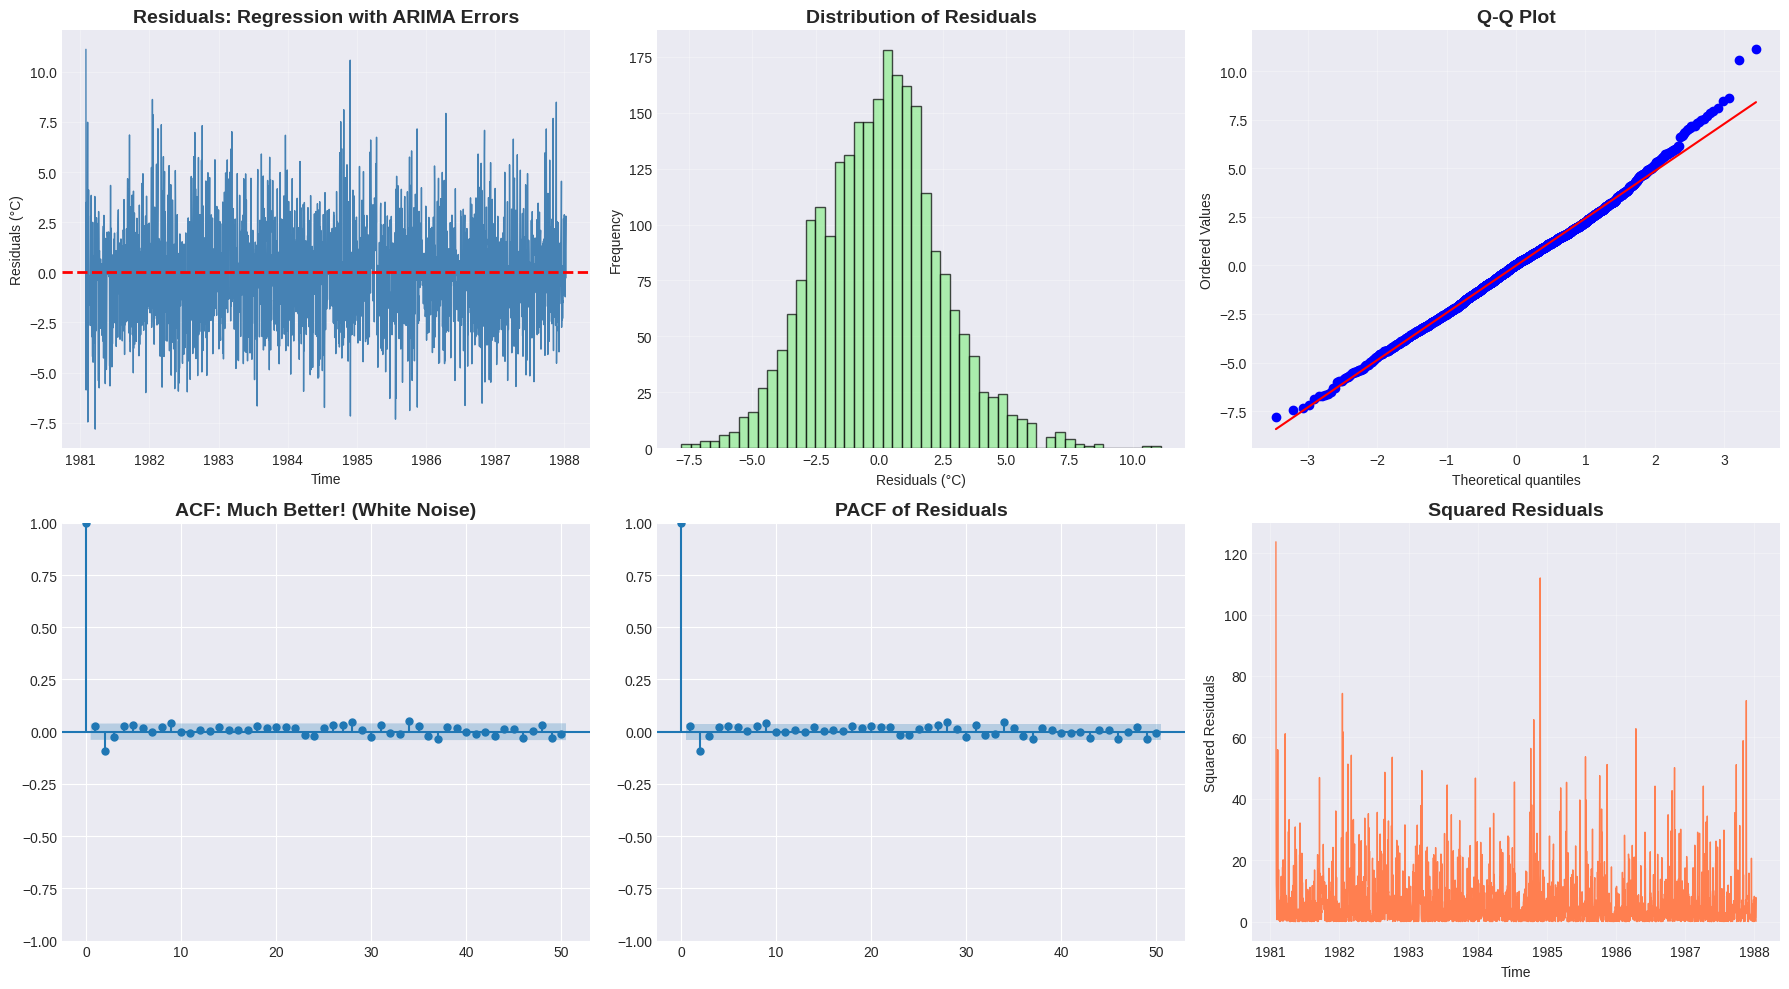

In [27]:
reg_arima_residuals = reg_arima_fitted.resid

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Residuals over time
axes[0, 0].plot(reg_arima_residuals, linewidth=1, color='steelblue')
axes[0, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_title('Residuals: Regression with ARIMA Errors', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Residuals (°C)')
axes[0, 0].grid(True, alpha=0.3)

# Residuals histogram
axes[0, 1].hist(reg_arima_residuals, bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 1].set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Residuals (°C)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plot
from scipy import stats
stats.probplot(reg_arima_residuals, dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('Q-Q Plot', fontsize=14, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# ACF of residuals - Should be white noise now!
plot_acf(reg_arima_residuals, lags=50, ax=axes[1, 0])
axes[1, 0].set_title('ACF: Much Better! (White Noise)', fontsize=14, fontweight='bold')

# PACF of residuals
plot_pacf(reg_arima_residuals, lags=50, ax=axes[1, 1])
axes[1, 1].set_title('PACF of Residuals', fontsize=14, fontweight='bold')

# Squared residuals
axes[1, 2].plot(reg_arima_residuals**2, linewidth=1, color='coral')
axes[1, 2].set_title('Squared Residuals', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Time')
axes[1, 2].set_ylabel('Squared Residuals')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. 예측 결과 시각화

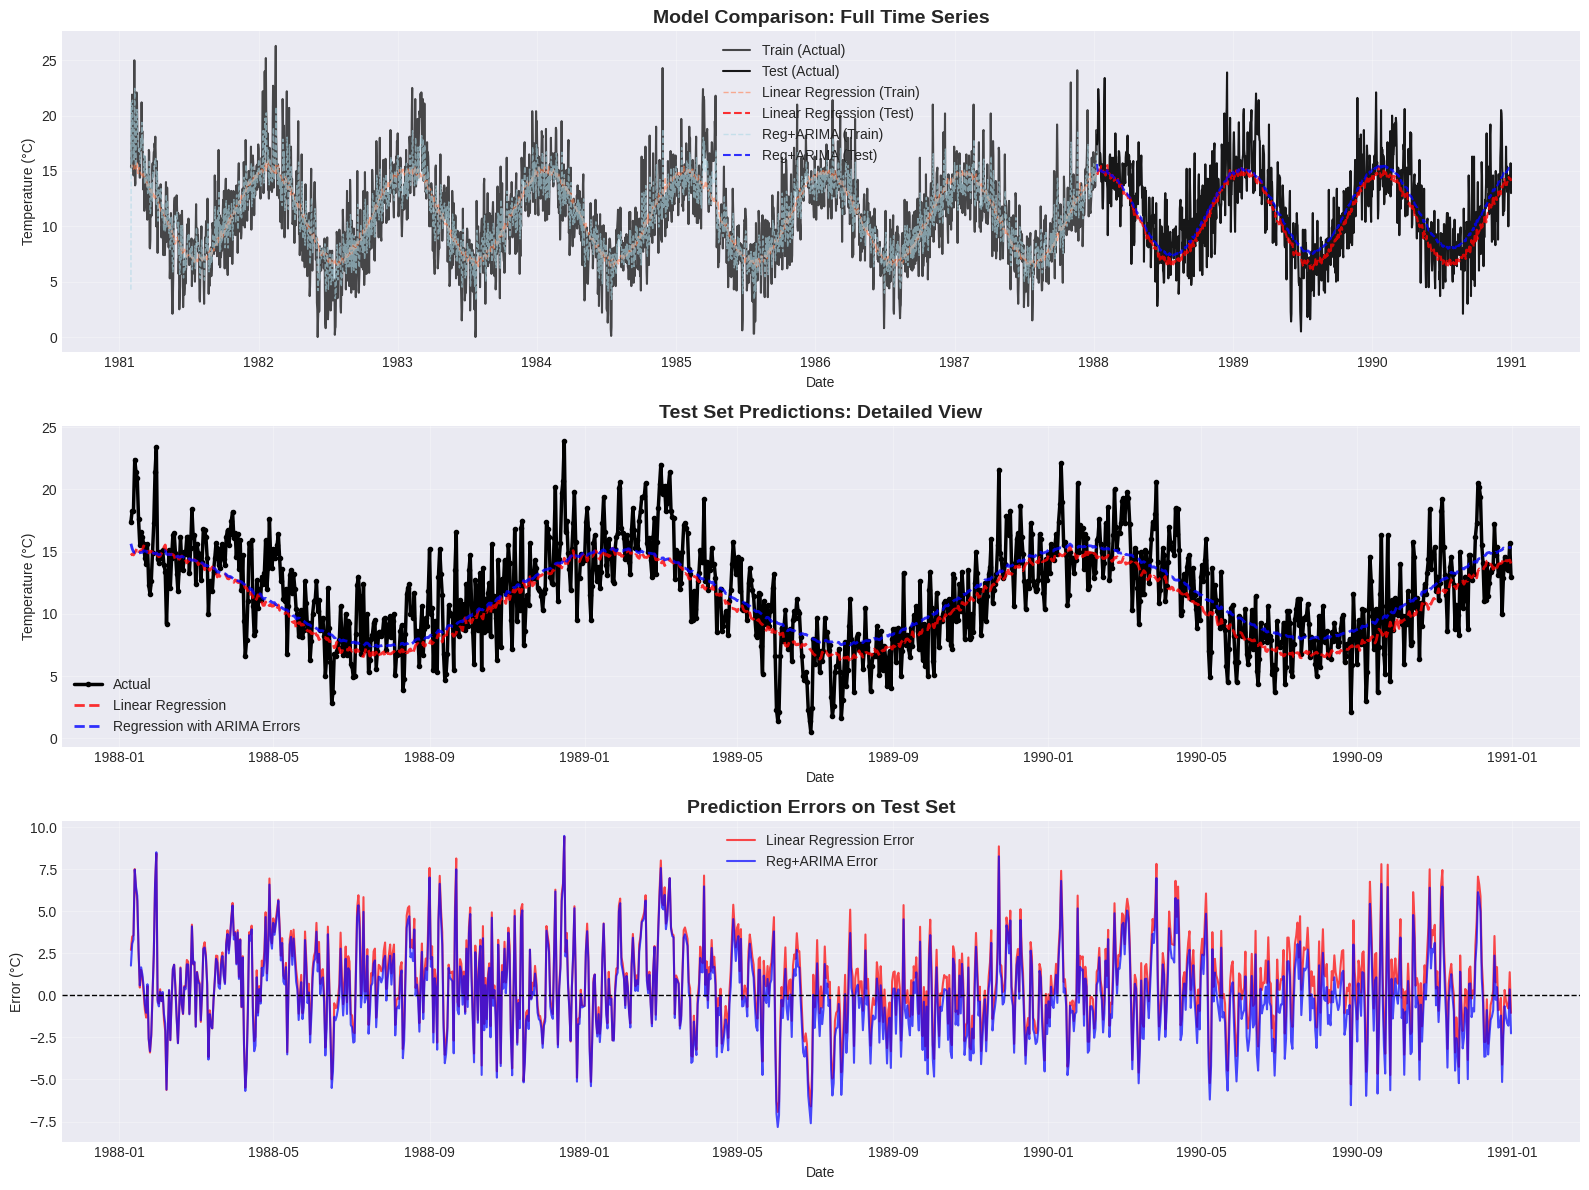

In [28]:
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Full comparison
axes[0].plot(train.index, train['Temp'], label='Train (Actual)', linewidth=1.5, color='black', alpha=0.7)
axes[0].plot(test.index, test['Temp'], label='Test (Actual)', linewidth=1.5, color='black', alpha=0.9)
axes[0].plot(train.index, lr_train_pred, label='Linear Regression (Train)',
             linewidth=1, linestyle='--', alpha=0.6, color='coral')
axes[0].plot(test.index, lr_test_pred, label='Linear Regression (Test)',
             linewidth=1.5, linestyle='--', alpha=0.8, color='red')
axes[0].plot(train.index, reg_arima_train_pred, label='Reg+ARIMA (Train)',
             linewidth=1, linestyle='--', alpha=0.6, color='lightblue')
axes[0].plot(test.index, reg_arima_test_pred, label='Reg+ARIMA (Test)',
             linewidth=1.5, linestyle='--', alpha=0.8, color='blue')
axes[0].set_title('Model Comparison: Full Time Series', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Temperature (°C)')
axes[0].legend(loc='best')
axes[0].grid(True, alpha=0.3)

# Test set zoom
axes[1].plot(test.index, test['Temp'], label='Actual',
             linewidth=2.5, marker='o', markersize=3, color='black')
axes[1].plot(test.index, lr_test_pred, label='Linear Regression',
             linewidth=2, linestyle='--', alpha=0.8, color='red')
axes[1].plot(test.index, reg_arima_test_pred, label='Regression with ARIMA Errors',
             linewidth=2, linestyle='--', alpha=0.8, color='blue')
axes[1].set_title('Test Set Predictions: Detailed View', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Temperature (°C)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Error comparison
test['lr_error'] = test['Temp'] - lr_test_pred
test['reg_arima_error'] = test['Temp'] - reg_arima_test_pred.values

axes[2].plot(test.index, test['lr_error'], label='Linear Regression Error',
             linewidth=1.5, alpha=0.7, color='red')
axes[2].plot(test.index, test['reg_arima_error'], label='Reg+ARIMA Error',
             linewidth=1.5, alpha=0.7, color='blue')
axes[2].axhline(y=0, color='black', linestyle='--', linewidth=1)
axes[2].set_title('Prediction Errors on Test Set', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Error (°C)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 실습: Dynamic Harmonic Regression with ARIMAX

동적 조화 회귀(Dynamic Harmonic Regression)는 푸리에 항을 사용하여 계절성을 유연하게 모형화하며,
추세 변수를 함께 포함한 ARIMAX 프레임워크 내에서 적용할 수 있습니다.

1. 데이터: 미국 소매 및 음식 서비스 판매액 (2014년 이후, 월별)
2. 모형: ARIMAX(1,1,1) + 동적 조화 회귀(Dynamic Harmonic Regression)
3. 외생 변수:
-  선형 추세(Linear trend)
- 3쌍의 푸리에 항(sin, cos)



## 1. 라이브러리 로드

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

## 2. 데이터 로드

In [30]:
from urllib.parse import urljoin
data_repo_url = "https://raw.githubusercontent.com/SLCFLAB/hd2025_time_series/refs/heads/main/datasets/"
df = pd.read_csv(urljoin(data_repo_url, "us_monthly_retail_sales.csv"))
df.columns = ['Date', 'Sales']
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.dropna(inplace=True)

In [31]:
df

,Sales
Date,
1992-01-01,159177
1992-02-01,159189
1992-03-01,158647
1992-04-01,159921
1992-05-01,160471
...,...
2025-04-01,721789
2025-05-01,716101
2025-06-01,723033


In [32]:
# 2014년 이후 데이터만 사용
df = df['2014-01-01':]

In [33]:
print(f"\n데이터 기간: {df.index[0]} ~ {df.index[-1]}")
print(f"데이터 개수: {len(df)}")
print(f"\n기술 통계량:")
print(df.describe())


데이터 기간: 2014-01-01 00:00:00 ~ 2025-08-01 00:00:00
데이터 개수: 140

기술 통계량:
               Sales
count     140.000000
mean   548470.871429
std    104438.086429
min    401028.000000
25%    453880.750000
50%    509186.500000
75%    662282.000000
max    732010.000000


## 3. 데이터 시각화

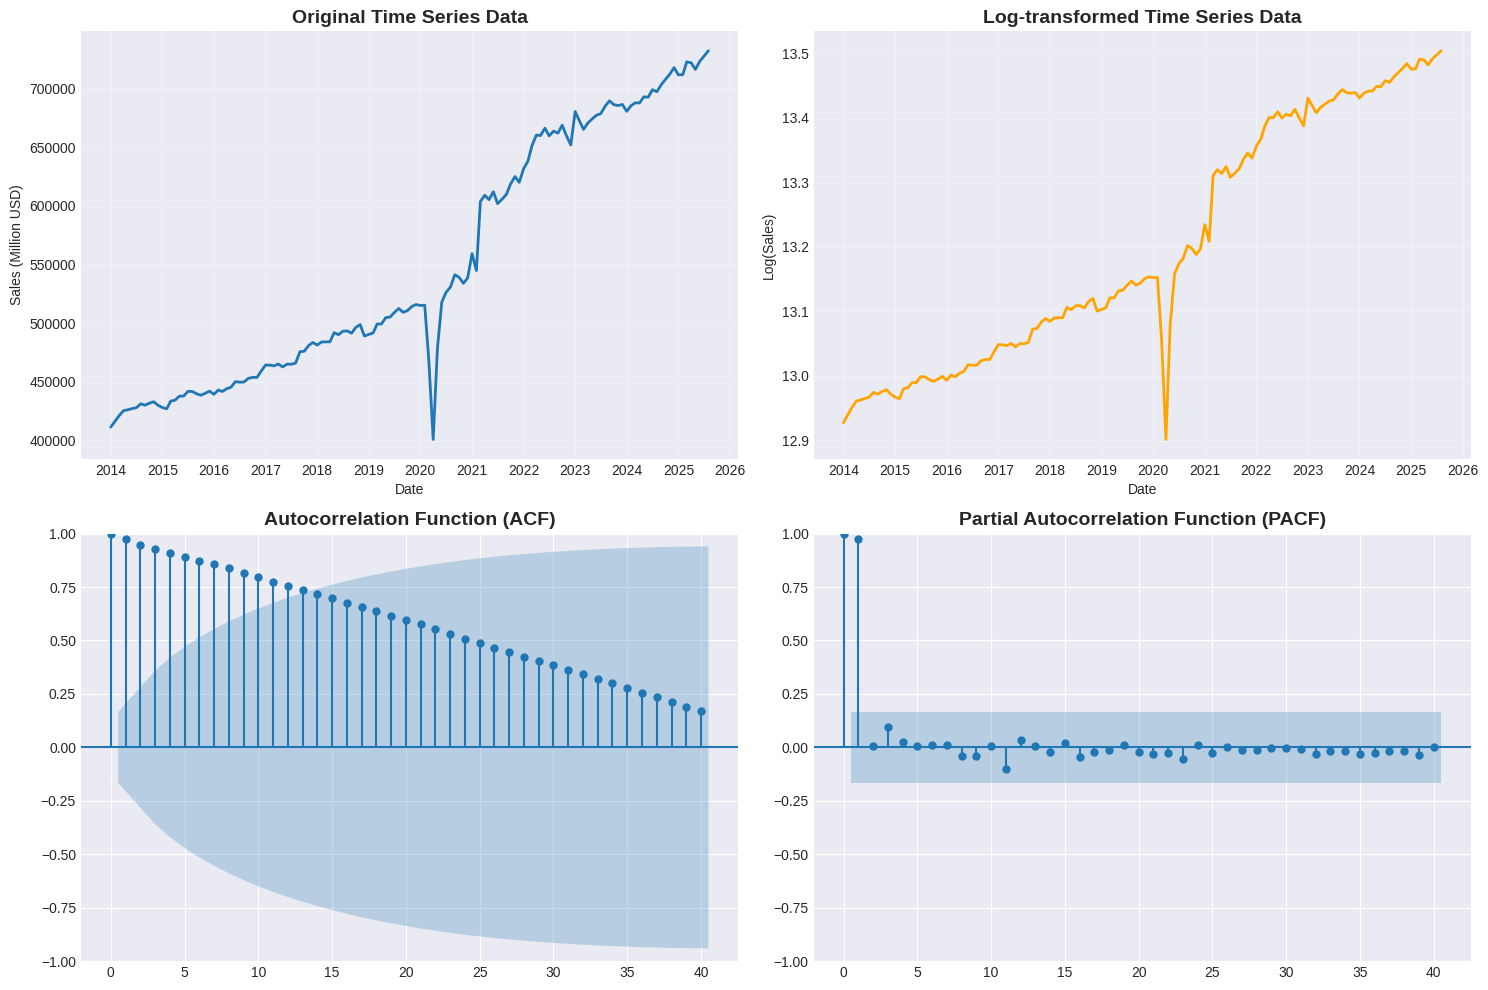

In [34]:
from matplotlib.dates import YearLocator, DateFormatter

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Original data
axes[0, 0].plot(df.index, df['Sales'], linewidth=2)
axes[0, 0].set_title('Original Time Series Data', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Sales (Million USD)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].xaxis.set_major_locator(YearLocator())
axes[0, 0].xaxis.set_major_formatter(DateFormatter('%Y'))

# Log-transformed data
df['log_sales'] = np.log(df['Sales'])
axes[0, 1].plot(df.index, df['log_sales'], linewidth=2, color='orange')
axes[0, 1].set_title('Log-transformed Time Series Data', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Log(Sales)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].xaxis.set_major_locator(YearLocator())
axes[0, 1].xaxis.set_major_formatter(DateFormatter('%Y'))

# ACF
plot_acf(df['log_sales'], lags=40, ax=axes[1, 0])
axes[1, 0].set_title('Autocorrelation Function (ACF)', fontsize=14, fontweight='bold')

# PACF
plot_pacf(df['log_sales'], lags=40, ax=axes[1, 1])
axes[1, 1].set_title('Partial Autocorrelation Function (PACF)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. Harmonic (Fourier) 변수 생성

In [35]:
def create_fourier_terms(index, period, K):
    """
    Create Fourier terms

    Parameters:
    -----------
    index : DatetimeIndex
        Time series index
    period : int
        Period (12 for monthly data)
    K : int
        Number of Fourier term pairs (generates K pairs of sin, cos)

    Returns:
    --------
    DataFrame with Fourier terms
    """
    t = np.arange(len(index))
    fourier_df = pd.DataFrame(index=index)

    for k in range(1, K + 1):
        fourier_df[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        fourier_df[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)

    return fourier_df

In [36]:
# For monthly data: period=12, K=3 (3 pairs of sin, cos)
K = 3
fourier_terms = create_fourier_terms(df.index, period=12, K=K)

In [37]:
print("\nGenerated Fourier terms:")
print(fourier_terms.head(10))


Generated Fourier terms:
                   sin_1         cos_1         sin_2  cos_2         sin_3  \
Date                                                                        
2014-01-01  0.000000e+00  1.000000e+00  0.000000e+00    1.0  0.000000e+00   
2014-02-01  5.000000e-01  8.660254e-01  8.660254e-01    0.5  1.000000e+00   
2014-03-01  8.660254e-01  5.000000e-01  8.660254e-01   -0.5  1.224647e-16   
2014-04-01  1.000000e+00  6.123234e-17  1.224647e-16   -1.0 -1.000000e+00   
2014-05-01  8.660254e-01 -5.000000e-01 -8.660254e-01   -0.5 -2.449294e-16   
2014-06-01  5.000000e-01 -8.660254e-01 -8.660254e-01    0.5  1.000000e+00   
2014-07-01  1.224647e-16 -1.000000e+00 -2.449294e-16    1.0  3.673940e-16   
2014-08-01 -5.000000e-01 -8.660254e-01  8.660254e-01    0.5 -1.000000e+00   
2014-09-01 -8.660254e-01 -5.000000e-01  8.660254e-01   -0.5 -4.898587e-16   
2014-10-01 -1.000000e+00 -1.836970e-16  3.673940e-16   -1.0  1.000000e+00   

                   cos_3  
Date                  

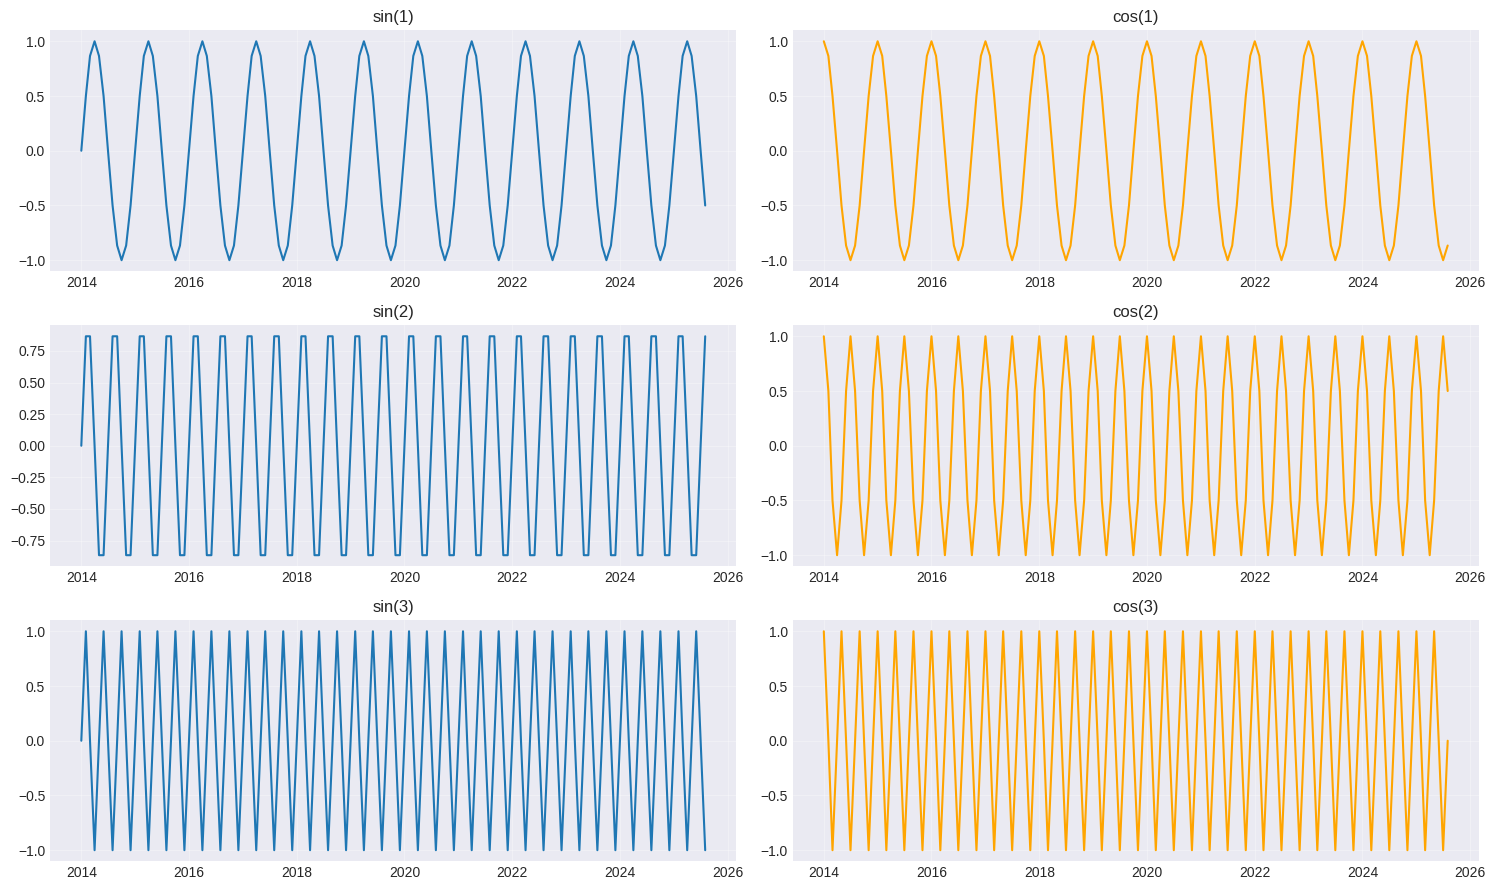

In [38]:
# Visualize Fourier terms
fig, axes = plt.subplots(K, 2, figsize=(15, 3*K))
for k in range(1, K + 1):
    axes[k-1, 0].plot(fourier_terms.index, fourier_terms[f'sin_{k}'])
    axes[k-1, 0].set_title(f'sin({k})', fontsize=12)
    axes[k-1, 0].grid(True, alpha=0.3)

    axes[k-1, 1].plot(fourier_terms.index, fourier_terms[f'cos_{k}'], color='orange')
    axes[k-1, 1].set_title(f'cos({k})', fontsize=12)
    axes[k-1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. 트렌드 변수 생성

In [39]:
# Linear trend
df['trend'] = np.arange(len(df))

print("\nTrend variable:")
print(df[['Sales', 'log_sales', 'trend']].head())


Trend variable:
             Sales  log_sales  trend
Date                                
2014-01-01  411561  12.927713      0
2014-02-01  416736  12.940208      1
2014-03-01  421230  12.950934      2
2014-04-01  425546  12.961128      3
2014-05-01  426253  12.962788      4


## 6. Train/Test 분리

In [40]:
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size].copy()
test = df.iloc[train_size:].copy()

In [41]:
train_fourier = fourier_terms.iloc[:train_size]
test_fourier = fourier_terms.iloc[train_size:]

In [42]:
print(f"Train data: {len(train)} observations")
print(f"Test data: {len(test)} observations")

Train data: 112 observations
Test data: 28 observations


## 7. ARIMAX with Trend and Harmonic Regression

In [43]:
# Prepare exogenous variables: trend + Fourier terms
exog_train = pd.concat([train[['trend']], train_fourier], axis=1)
exog_test = pd.concat([test[['trend']], test_fourier], axis=1)

In [44]:
print("Exogenous variables structure:")
exog_train.head()

Exogenous variables structure:


,trend,sin_1,cos_1,sin_2,cos_2,sin_3,cos_3
Date,,,,,,,
2014-01-01,0,0.000000,1.000000e+00,0.000000e+00,1.0,0.000000e+00,1.000000e+00
2014-02-01,1,0.500000,8.660254e-01,8.660254e-01,0.5,1.000000e+00,6.123234e-17
2014-03-01,2,0.866025,5.000000e-01,8.660254e-01,-0.5,1.224647e-16,-1.000000e+00
2014-04-01,3,1.000000,6.123234e-17,1.224647e-16,-1.0,-1.000000e+00,-1.836970e-16
2014-05-01,4,0.866025,-5.000000e-01,-8.660254e-01,-0.5,-2.449294e-16,1.000000e+00


In [45]:
# Fit ARIMAX model
# order=(1,1,1): ARIMA(1,1,1)
# seasonal_order=(0,0,0,0): Seasonality handled by Fourier terms
# trend='n': No internal trend (using exogenous trend variable)
model = SARIMAX(
    train['log_sales'],
    exog=exog_train,
    order=(1, 1, 1),
    seasonal_order=(0, 0, 0, 0),
    trend='n'
)

fitted_model = model.fit(disp=False)

In [46]:
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:              log_sales   No. Observations:                  112
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 242.912
Date:                Sat, 11 Oct 2025   AIC                           -465.824
Time:                        06:33:54   BIC                           -438.728
Sample:                    01-01-2014   HQIC                          -454.832
                         - 04-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
trend          0.0044      0.003      1.542      0.123      -0.001       0.010
sin_1         -0.0044      0.016     -0.281      0.778      -0.035       0.027
cos_1         -0.0044      0.017     -0.265      0.7

## 8. 예측 및 평가

In [47]:
# Train set predictions
train_pred = fitted_model.fittedvalues
train_pred_original = np.exp(train_pred)

In [48]:
# Test set predictions
test_pred = fitted_model.forecast(steps=len(test), exog=exog_test)
test_pred_original = np.exp(test_pred)

In [49]:
# Calculate evaluation metrics
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

train_mae = mean_absolute_error(train['Sales'][1:], train_pred_original[1:])
train_rmse = root_mean_squared_error(train['Sales'][1:], train_pred_original[1:])
train_mape = mean_absolute_percentage_error(train['Sales'][1:], train_pred_original[1:])

test_mae = mean_absolute_error(test['Sales'], test_pred_original)
test_rmse = root_mean_squared_error(test['Sales'], test_pred_original)
test_mape = mean_absolute_percentage_error(test['Sales'], test_pred_original)

In [50]:
print("Model Performance Evaluation")
print("="*50)
print(f"\n[Train Set]")
print(f"MAE:  {train_mae:.2f}")
print(f"RMSE: {train_rmse:.2f}")
print(f"MAPE: {train_mape*100:.2f}%")
print(f"\n[Test Set]")
print(f"MAE:  {test_mae:.2f}")
print(f"RMSE: {test_rmse:.2f}")
print(f"MAPE: {test_mape*100:.2f}%")

Model Performance Evaluation

[Train Set]
MAE:  6818.77
RMSE: 13287.24
MAPE: 1.34%

[Test Set]
MAE:  25215.52
RMSE: 27477.62
MAPE: 3.58%


## 9. 결과 시각화

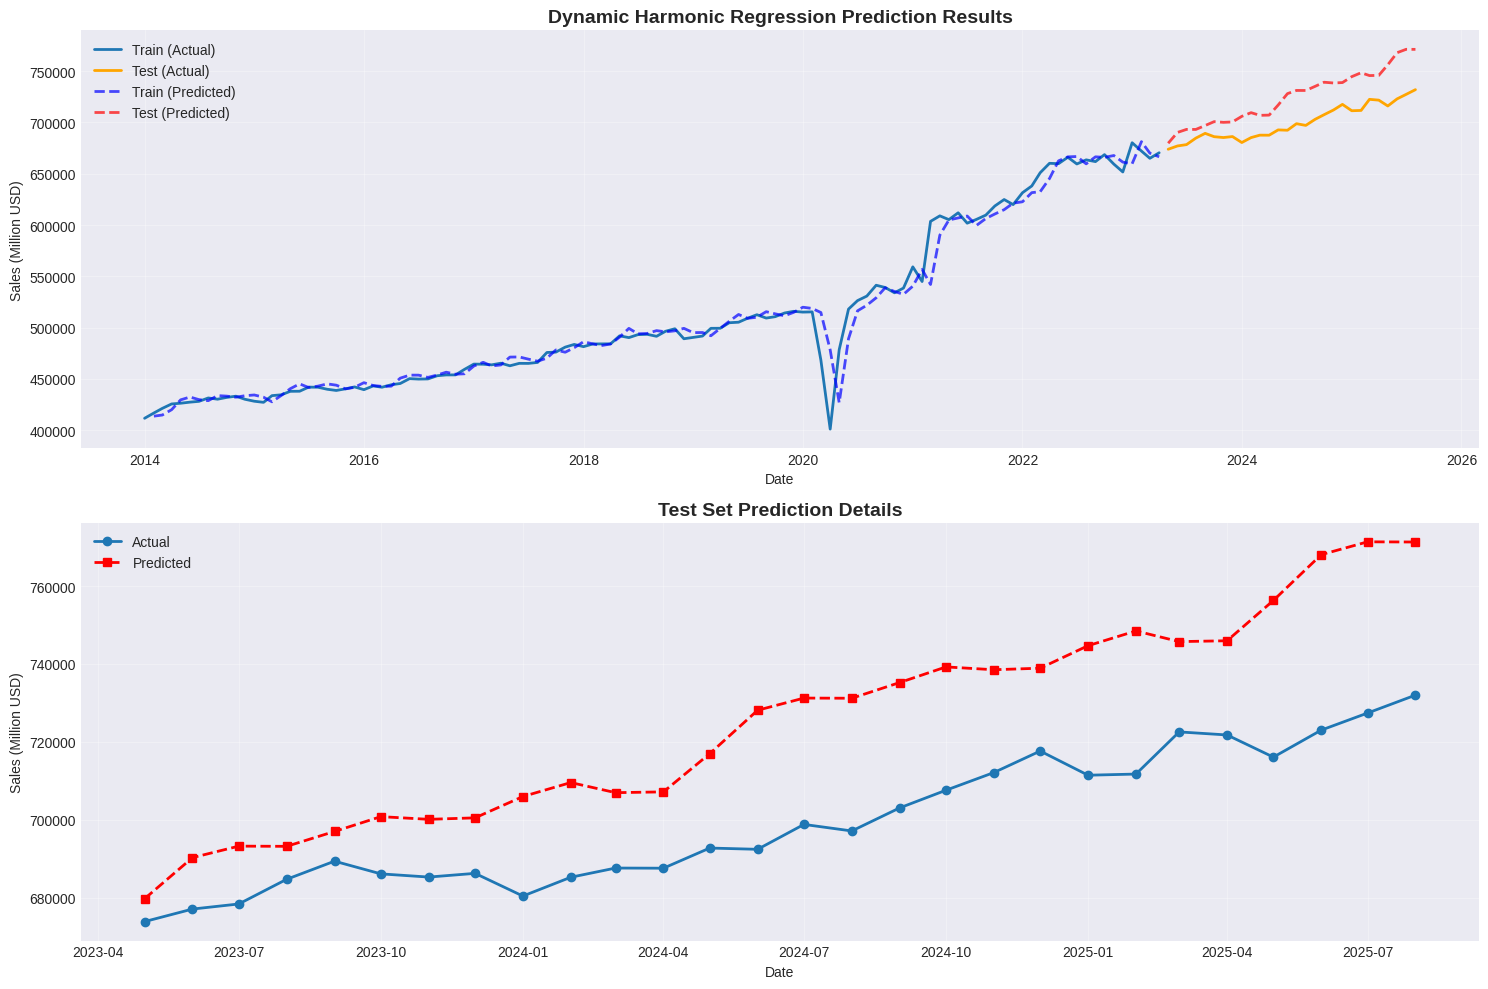

In [51]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Overall prediction results
axes[0].plot(train.index, train['Sales'], label='Train (Actual)', linewidth=2)
axes[0].plot(test.index, test['Sales'], label='Test (Actual)', linewidth=2, color='orange')
axes[0].plot(train.index[1:], train_pred_original[1:], label='Train (Predicted)',
             linewidth=2, linestyle='--', alpha=0.7, color='blue')
axes[0].plot(test.index, test_pred_original, label='Test (Predicted)',
             linewidth=2, linestyle='--', alpha=0.7, color='red')
axes[0].set_title('Dynamic Harmonic Regression Prediction Results', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Sales (Million USD)')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Test set zoom-in
axes[1].plot(test.index, test['Sales'], label='Actual',
             linewidth=2, marker='o', markersize=6)
axes[1].plot(test.index, test_pred_original, label='Predicted',
             linewidth=2, marker='s', markersize=6, linestyle='--', color='red')
axes[1].set_title('Test Set Prediction Details', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Sales (Million USD)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 실습: SARIMAX

일반적인 SARIMA 모형의 경우도 `statsmodels.tsa.statespace.sarimax.SARIMAX`를 통해 구현합니다. 이를 실습해 보겠습니다.

## 1. 라이브러리 로드

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')

## 데이터 로드 (호주 와인 판매 데이터)

Australian wine sales data (monthly)
- Source: Rob Hyndman's Time Series Data Library

In [53]:
wine_data_path = urljoin(data_repo_url, "aus_wine_sales.csv")
df = pd.read_csv(wine_data_path)
df.columns = ['date', 'sales']
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [54]:
df

,sales
date,
1991-07-01,3.526591
1991-08-01,3.180891
1991-09-01,3.252221
1991-10-01,3.611003
1991-11-01,3.565869
...,...
2008-02-01,21.654285
2008-03-01,18.264945
2008-04-01,23.107677


In [55]:
df.describe()

,sales
count,204.000000
mean,10.694430
std,5.956998
min,2.814520
25%,5.844095
50%,9.319345
75%,14.289964
max,29.665356


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204 entries, 1991-07-01 to 2008-06-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   204 non-null    float64
dtypes: float64(1)
memory usage: 3.2 KB


## 3. EDA

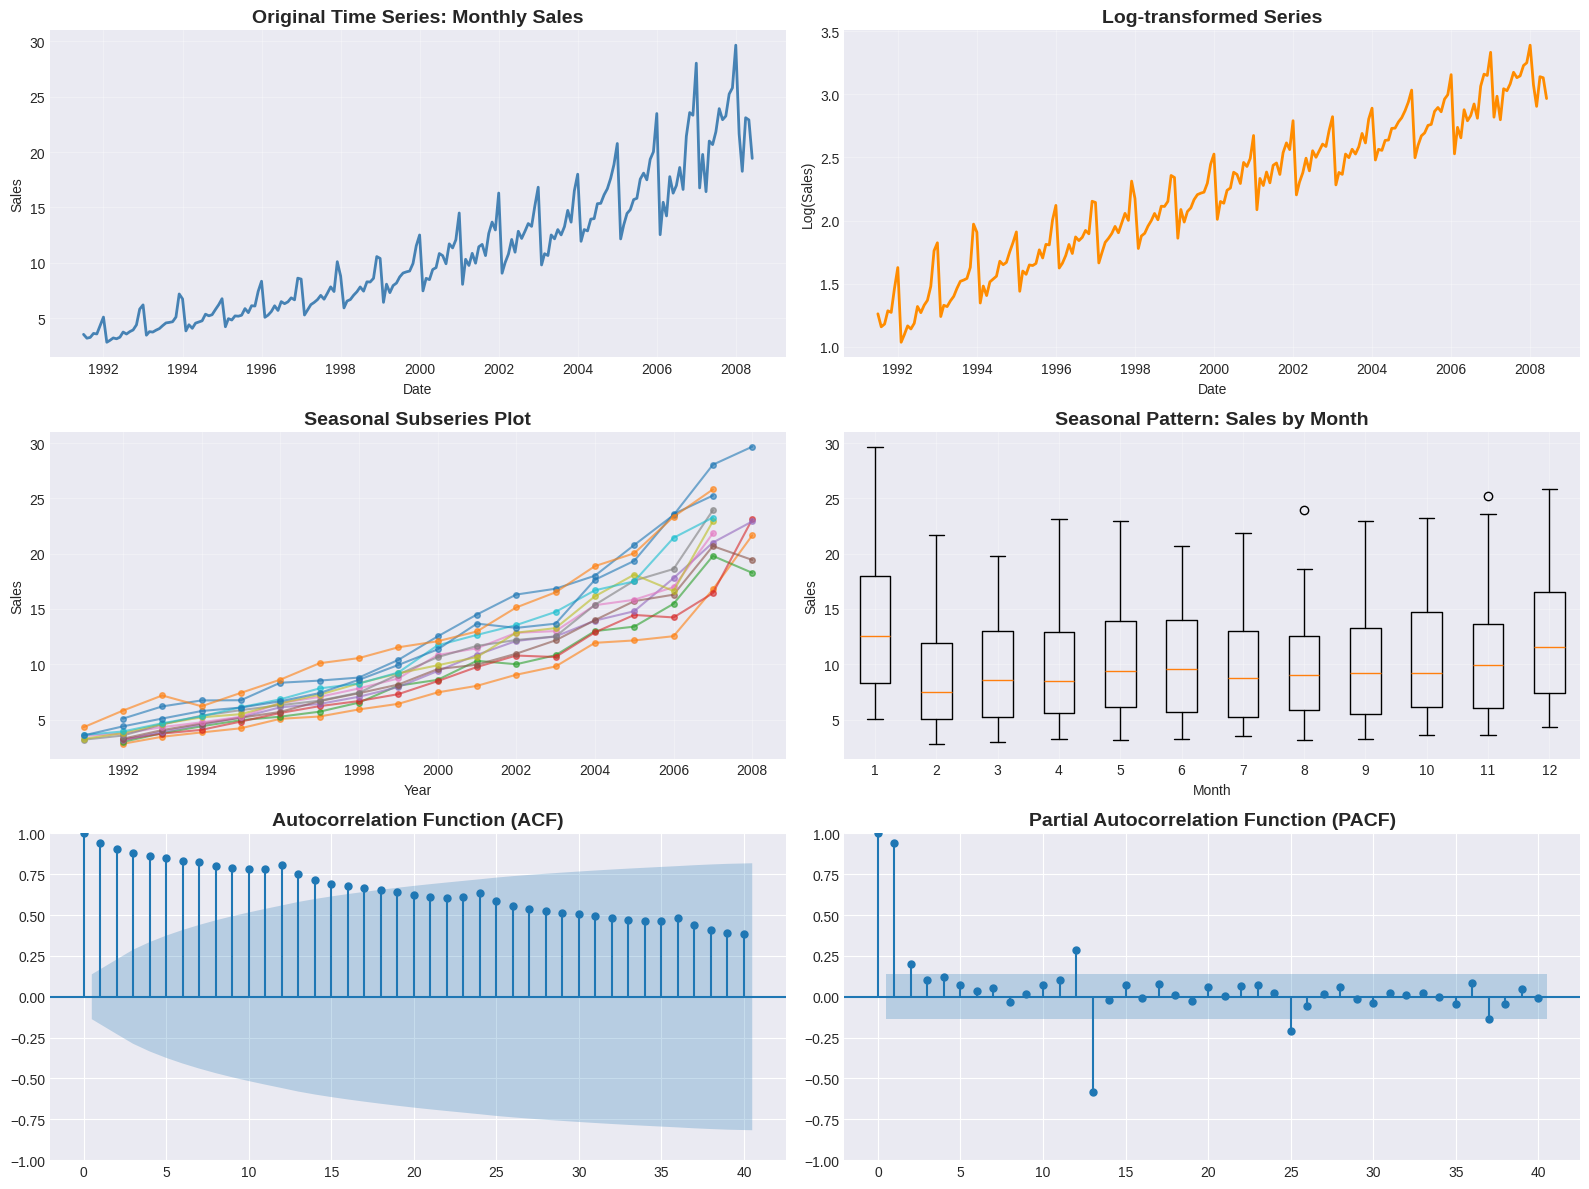

In [57]:
fig, axes = plt.subplots(3, 2, figsize=(16, 12))

# Original time series
axes[0, 0].plot(df.index, df['sales'], linewidth=2, color='steelblue')
axes[0, 0].set_title('Original Time Series: Monthly Sales', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Sales')
axes[0, 0].grid(True, alpha=0.3)

# Log-transformed series
df['log_sales'] = np.log(df['sales'])
axes[0, 1].plot(df.index, df['log_sales'], linewidth=2, color='darkorange')
axes[0, 1].set_title('Log-transformed Series', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Log(Sales)')
axes[0, 1].grid(True, alpha=0.3)

# Seasonal subseries plot
df['month'] = df.index.month
df['year'] = df.index.year
for month in range(1, 13):
    month_data = df[df['month'] == month]
    axes[1, 0].plot(month_data['year'], month_data['sales'], marker='o', markersize=4, alpha=0.6)
axes[1, 0].set_title('Seasonal Subseries Plot', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Year')
axes[1, 0].set_ylabel('Sales')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Boxplot by month
monthly_data = [df[df['month'] == m]['sales'].values for m in range(1, 13)]
axes[1, 1].boxplot(monthly_data, labels=range(1, 13))
axes[1, 1].set_title('Seasonal Pattern: Sales by Month', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Sales')
axes[1, 1].grid(True, alpha=0.3)

# ACF
plot_acf(df['log_sales'], lags=40, ax=axes[2, 0])
axes[2, 0].set_title('Autocorrelation Function (ACF)', fontsize=14, fontweight='bold')

# PACF
plot_pacf(df['log_sales'], lags=40, ax=axes[2, 1])
axes[2, 1].set_title('Partial Autocorrelation Function (PACF)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 4. 정상성 검정 (Augmented Dickey-Fuller Test)

In [58]:
def adf_test(series, name=''):
    """
    Perform Augmented Dickey-Fuller test
    """
    result = adfuller(series.dropna())
    print(f'\n{"="*50}')
    print(f'ADF Test Results for {name}')
    print(f'{"="*50}')
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value: {result[1]:.6f}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'    {key}: {value:.3f}')

    if result[1] <= 0.05:
        print(f"\n=> Reject null hypothesis. Series is stationary.")
    else:
        print(f"\n=> Fail to reject null hypothesis. Series is non-stationary.")

    return result

In [59]:
# Test original series
adf_original = adf_test(df['log_sales'], 'Log Sales (Original)')

# Test first-differenced series
df['log_sales_diff1'] = df['log_sales'].diff()
adf_diff1 = adf_test(df['log_sales_diff1'], 'Log Sales (First Difference)')

# Test seasonal differenced series
df['log_sales_seasonal_diff'] = df['log_sales'].diff(12)
adf_seasonal = adf_test(df['log_sales_seasonal_diff'], 'Log Sales (Seasonal Difference)')


ADF Test Results for Log Sales (Original)
ADF Statistic: -0.988733
p-value: 0.757351
Critical Values:
    1%: -3.465
    5%: -2.877
    10%: -2.575

=> Fail to reject null hypothesis. Series is non-stationary.

ADF Test Results for Log Sales (First Difference)
ADF Statistic: -4.519432
p-value: 0.000181
Critical Values:
    1%: -3.465
    5%: -2.877
    10%: -2.575

=> Reject null hypothesis. Series is stationary.

ADF Test Results for Log Sales (Seasonal Difference)
ADF Statistic: -5.214559
p-value: 0.000008
Critical Values:
    1%: -3.467
    5%: -2.878
    10%: -2.575

=> Reject null hypothesis. Series is stationary.


## 5. 차분 후 시각화

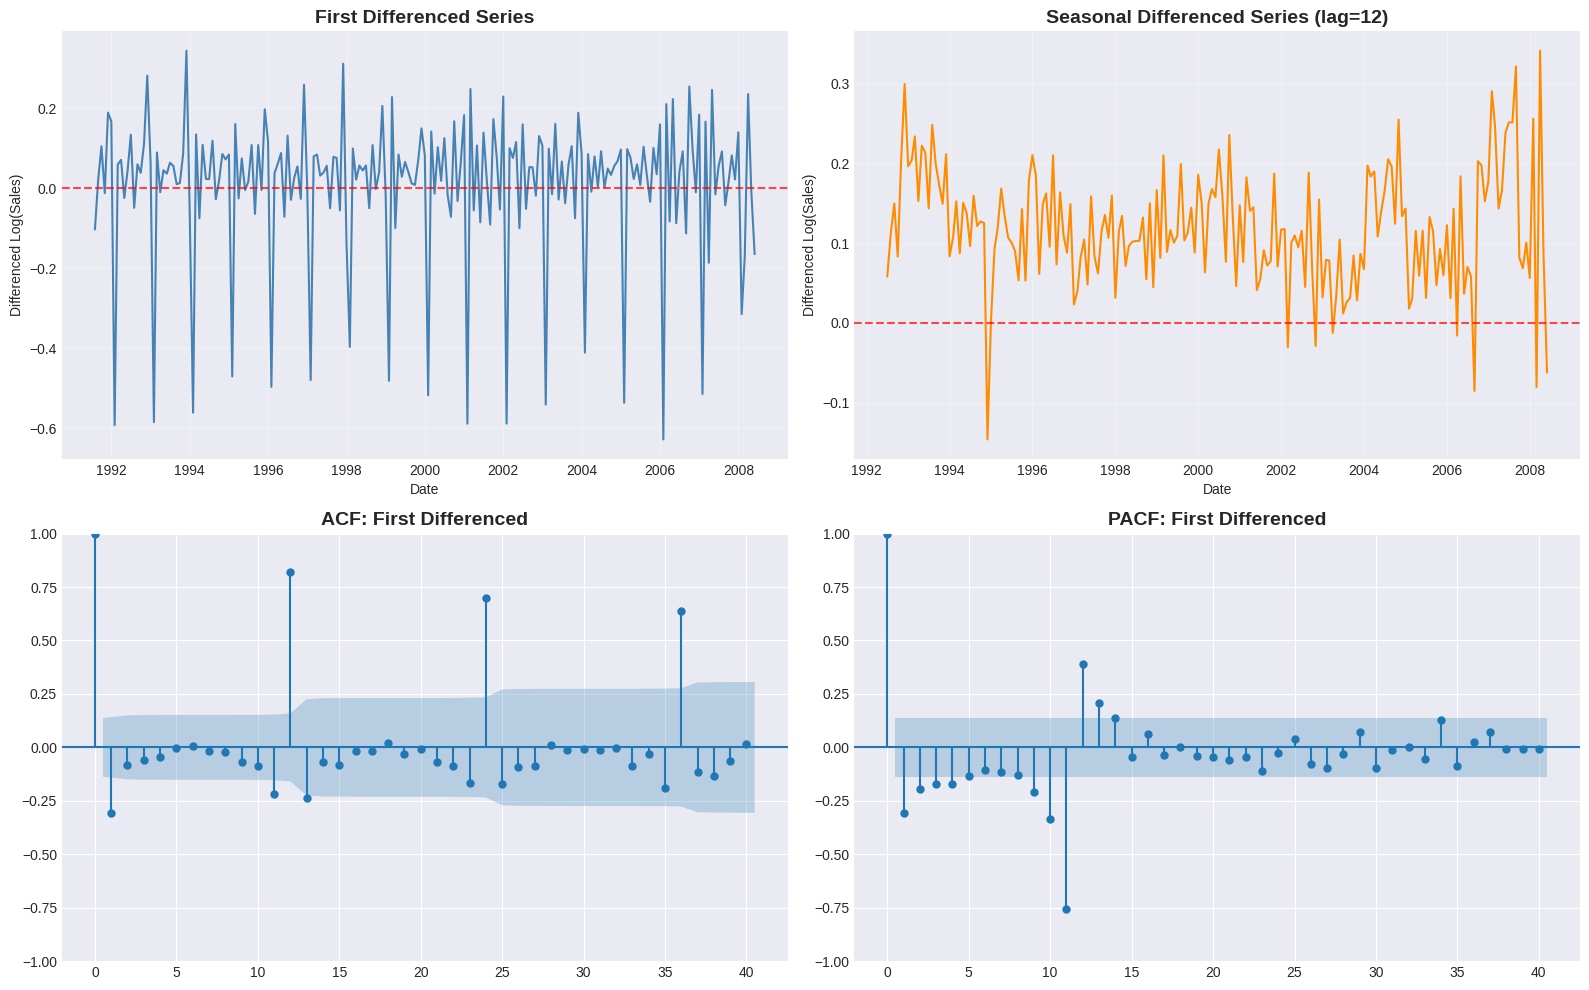

In [60]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# First difference
axes[0, 0].plot(df.index, df['log_sales_diff1'], linewidth=1.5, color='steelblue')
axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[0, 0].set_title('First Differenced Series', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Differenced Log(Sales)')
axes[0, 0].grid(True, alpha=0.3)

# Seasonal difference
axes[0, 1].plot(df.index, df['log_sales_seasonal_diff'], linewidth=1.5, color='darkorange')
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7)
axes[0, 1].set_title('Seasonal Differenced Series (lag=12)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Differenced Log(Sales)')
axes[0, 1].grid(True, alpha=0.3)

# ACF of differenced series
plot_acf(df['log_sales_diff1'].dropna(), lags=40, ax=axes[1, 0])
axes[1, 0].set_title('ACF: First Differenced', fontsize=14, fontweight='bold')

# PACF of differenced series
plot_pacf(df['log_sales_diff1'].dropna(), lags=40, ax=axes[1, 1])
axes[1, 1].set_title('PACF: First Differenced', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

1. First Differenced Series (왼쪽 위)
- **의미**: 1차 차분 (현재값 - 이전값)으로 트렌드를 제거한 시계열
- **해석**:
  - 0을 중심으로 진동하고 있어 트렌드가 제거됨
  - 하지만 여전히 **강한 계절성 패턴**이 보임 (규칙적인 큰 하락들이 12개월 간격으로 반복)
  - 분산이 일정해 보임 (로그 변환이 효과적이었음)

2. Seasonal Differenced Series (오른쪽 위)
- **의미**: 계절 차분 (현재값 - 12개월 전 값)으로 계절성을 제거한 시계열
- **해석**:
  - 0 근처에서 변동하며 계절성이 많이 제거됨
  - First difference보다 진폭이 작고 안정적
  - 여전히 약간의 패턴이 남아있음 → **추가 차분 필요** (d=1, D=1)

3. ACF: First Differenced (왼쪽 아래)
- **중요한 패턴들**:
  - **Lag 12, 24, 36에서 큰 스파이크** → 강한 계절성이 남아있음
  - Lag 1에서 음의 상관관계 (전형적인 overdifferencing 신호는 아님)
  - 천천히 감소하는 패턴 → MA 항 필요

**해석**: 1차 차분만으로는 계절성이 제거되지 않았음. **계절 차분(D=1) 추가 필요**

4. PACF: First Differenced (오른쪽 아래)
- **중요한 패턴들**:
  - Lag 1에서 큰 양의 스파이크 → **AR(1) 필요**
  - Lag 12에서 큰 음의 스파이크 → **계절 AR 또는 MA 필요**
  - Lag 13, 14에서도 유의미한 스파이크

**해석**:
- 비계절 부분: p=1 또는 2
- 계절 부분: P=1 고려

## 종합 해석 및 모델 선택 가이드

```
ACF/PACF 패턴으로 보는 SARIMA 차수 결정:

1. d=1 필요: 원시계열이 비정상 (트렌드 존재)
2. D=1 필요: 1차 차분 후에도 계절성 패턴 명확 (lag 12, 24, 36)
3. p=1~2: PACF가 lag 1에서 컷오프
4. q=1~2: ACF가 천천히 감소
5. P=0~1: PACF의 lag 12 패턴
6. Q=1~2: ACF의 계절 패턴

```

이런 이유로 코드에서 SARIMA(1,1,1)(1,1,1,12)를 수동 모델로 선택한 것이고, Grid Search로 더 나은 조합을 찾는 것이 목표!

## 6. Train/Test 분리

In [61]:
train_size = int(len(df) * 0.85)
train = df.iloc[:train_size].copy()
test = df.iloc[train_size:].copy()

print(f"\nTrain data: {len(train)} observations ({train.index[0]} to {train.index[-1]})")
print(f"Test data: {len(test)} observations ({test.index[0]} to {test.index[-1]})")


Train data: 173 observations (1991-07-01 00:00:00 to 2005-11-01 00:00:00)
Test data: 31 observations (2005-12-01 00:00:00 to 2008-06-01 00:00:00)


## 7. SARIMAX Fitting

Model specification: **SARIMA(p,d,q)(P,D,Q)m**
- p: AR order (non-seasonal)
- d: Differencing order (non-seasonal)
- q: MA order (non-seasonal)
- P: Seasonal AR order
- D: Seasonal differencing order
- Q: Seasonal MA order
- m: Seasonal period (12 for monthly data)

In [62]:
# Based on ACF/PACF analysis, we'll try SARIMA(1,1,1)(1,1,1,12)
print("\nFitting SARIMAX(1,1,1)(1,1,1,12) model...")

model = SARIMAX(
    train['log_sales'],
    order=(1, 1, 1),           # (p, d, q)
    seasonal_order=(1, 1, 1, 12),  # (P, D, Q, m)
    enforce_stationarity=False,
    enforce_invertibility=False
)

fitted_model = model.fit(disp=False)
print("\nModel fitting completed!")
print(fitted_model.summary())


Fitting SARIMAX(1,1,1)(1,1,1,12) model...

Model fitting completed!
                                     SARIMAX Results                                      
Dep. Variable:                          log_sales   No. Observations:                  173
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 216.920
Date:                            Sat, 11 Oct 2025   AIC                           -423.841
Time:                                    06:33:59   BIC                           -408.923
Sample:                                07-01-1991   HQIC                          -417.779
                                     - 11-01-2005                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0541      0.094     -0.573  

## 8. 모델 진단

잔차를 활용하여 모델 진단

In [63]:
residuals = fitted_model.resid

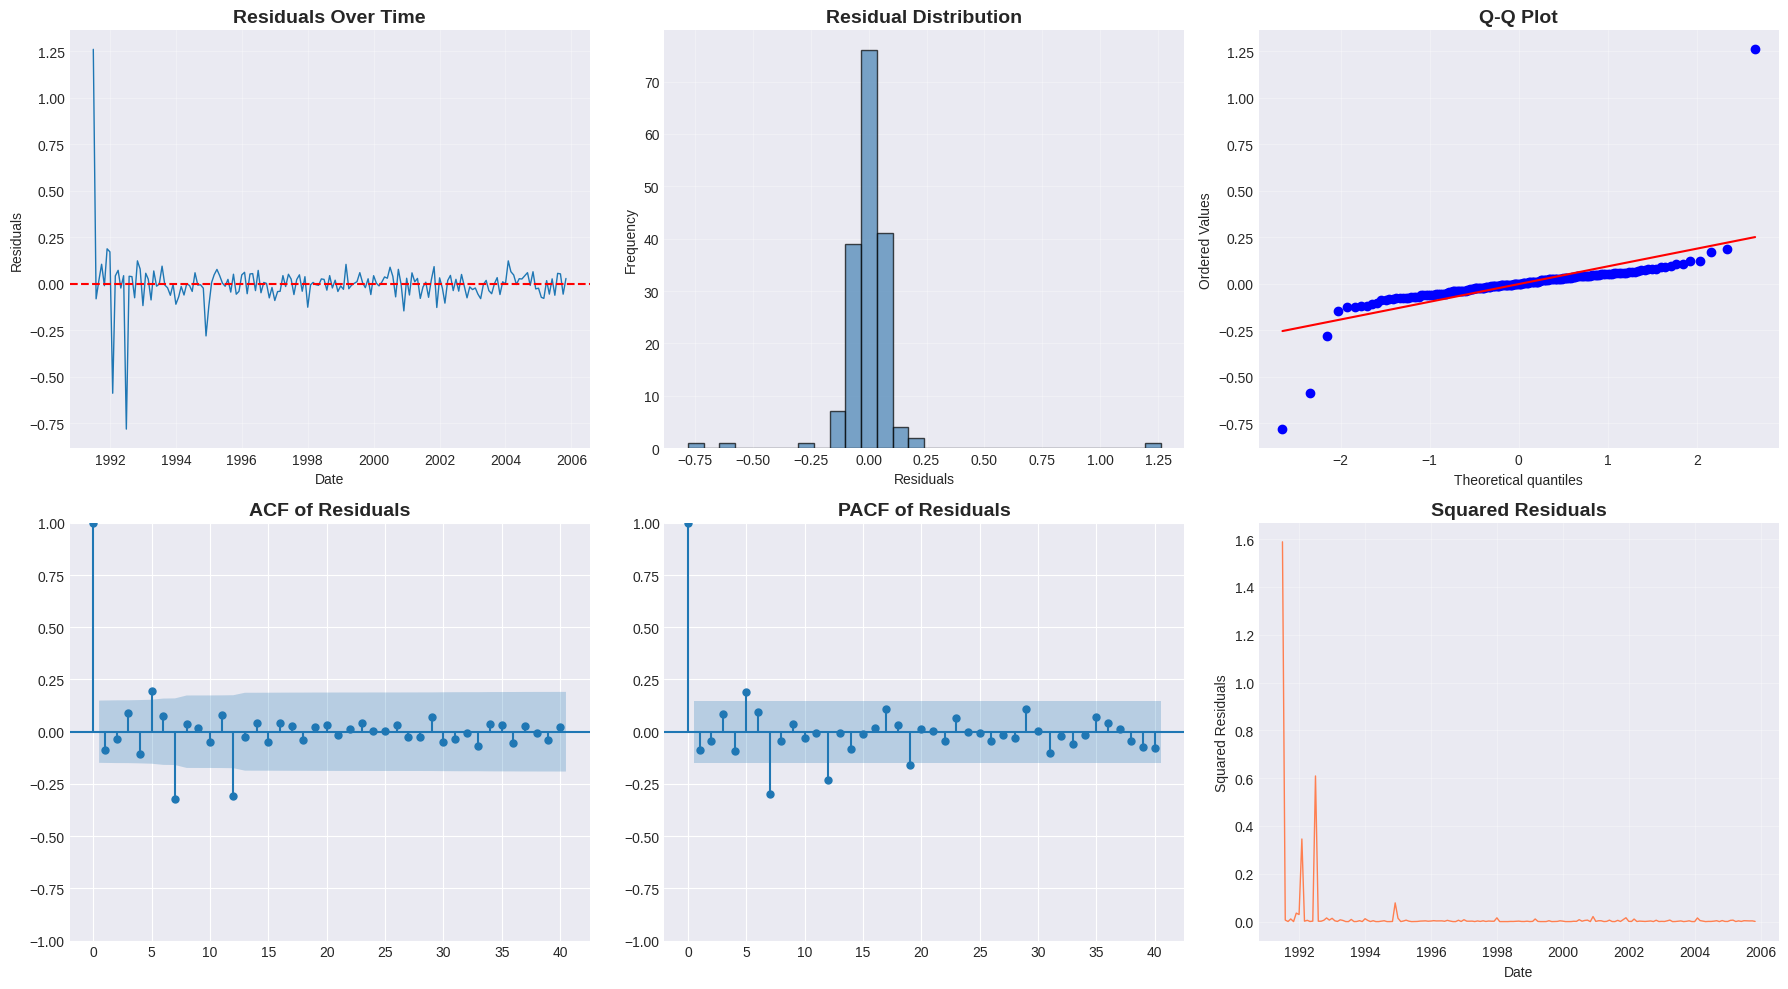

In [64]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Residual plot
axes[0, 0].plot(residuals, linewidth=1)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_title('Residuals Over Time', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].grid(True, alpha=0.3)

# Histogram
axes[0, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].set_title('Residual Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Residuals')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('Q-Q Plot', fontsize=14, fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)

# ACF of residuals
plot_acf(residuals, lags=40, ax=axes[1, 0])
axes[1, 0].set_title('ACF of Residuals', fontsize=14, fontweight='bold')

# PACF of residuals
plot_pacf(residuals, lags=40, ax=axes[1, 1])
axes[1, 1].set_title('PACF of Residuals', fontsize=14, fontweight='bold')

# Residuals squared (check for heteroscedasticity)
axes[1, 2].plot(residuals**2, linewidth=1, color='coral')
axes[1, 2].set_title('Squared Residuals', fontsize=14, fontweight='bold')
axes[1, 2].set_xlabel('Date')
axes[1, 2].set_ylabel('Squared Residuals')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [65]:
# Ljung-Box test for residual autocorrelation
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("\n" + "="*50)
print("Ljung-Box Test (Residual Autocorrelation)")
print("="*50)
print(lb_test)
print("\n* If p-value > 0.05, residuals show no autocorrelation (good)")


Ljung-Box Test (Residual Autocorrelation)
      lb_stat  lb_pvalue
10  32.829575   0.000291
20  53.904462   0.000060
30  56.436923   0.002432

* If p-value > 0.05, residuals show no autocorrelation (good)


## 9. 예측 및 평가

In [66]:
# In-sample predictions
train_pred = fitted_model.fittedvalues
train_pred_original = np.exp(train_pred)

# Out-of-sample forecast
forecast_steps = len(test)
forecast = fitted_model.forecast(steps=forecast_steps)
forecast_original = np.exp(forecast)

# Calculate prediction intervals
forecast_obj = fitted_model.get_forecast(steps=forecast_steps)
forecast_ci = forecast_obj.conf_int()
forecast_ci_original = np.exp(forecast_ci)

In [67]:
# Evaluation metrics
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error

train_mae = mean_absolute_error(train['sales'][1:], train_pred_original[1:])
train_rmse = root_mean_squared_error(train['sales'][1:], train_pred_original[1:])
train_mape = mean_absolute_percentage_error(train['sales'][1:], train_pred_original[1:])

test_mae = mean_absolute_error(test['sales'], forecast_original)
test_rmse = root_mean_squared_error(test['sales'], forecast_original)
test_mape = mean_absolute_percentage_error(test['sales'], forecast_original)

In [68]:
print("\n" + "="*50)
print("Model Performance Evaluation")
print("="*50)
print(f"\n[Train Set]")
print(f"MAE:  {train_mae:.2f}")
print(f"RMSE: {train_rmse:.2f}")
print(f"MAPE: {train_mape*100:.2f}%")
print(f"\n[Test Set]")
print(f"MAE:  {test_mae:.2f}")
print(f"RMSE: {test_rmse:.2f}")
print(f"MAPE: {test_mape*100:.2f}%")


Model Performance Evaluation

[Train Set]
MAE:  0.43
RMSE: 0.66
MAPE: 5.67%

[Test Set]
MAE:  1.53
RMSE: 1.82
MAPE: 7.52%


## 10. 예측 결과 시각화

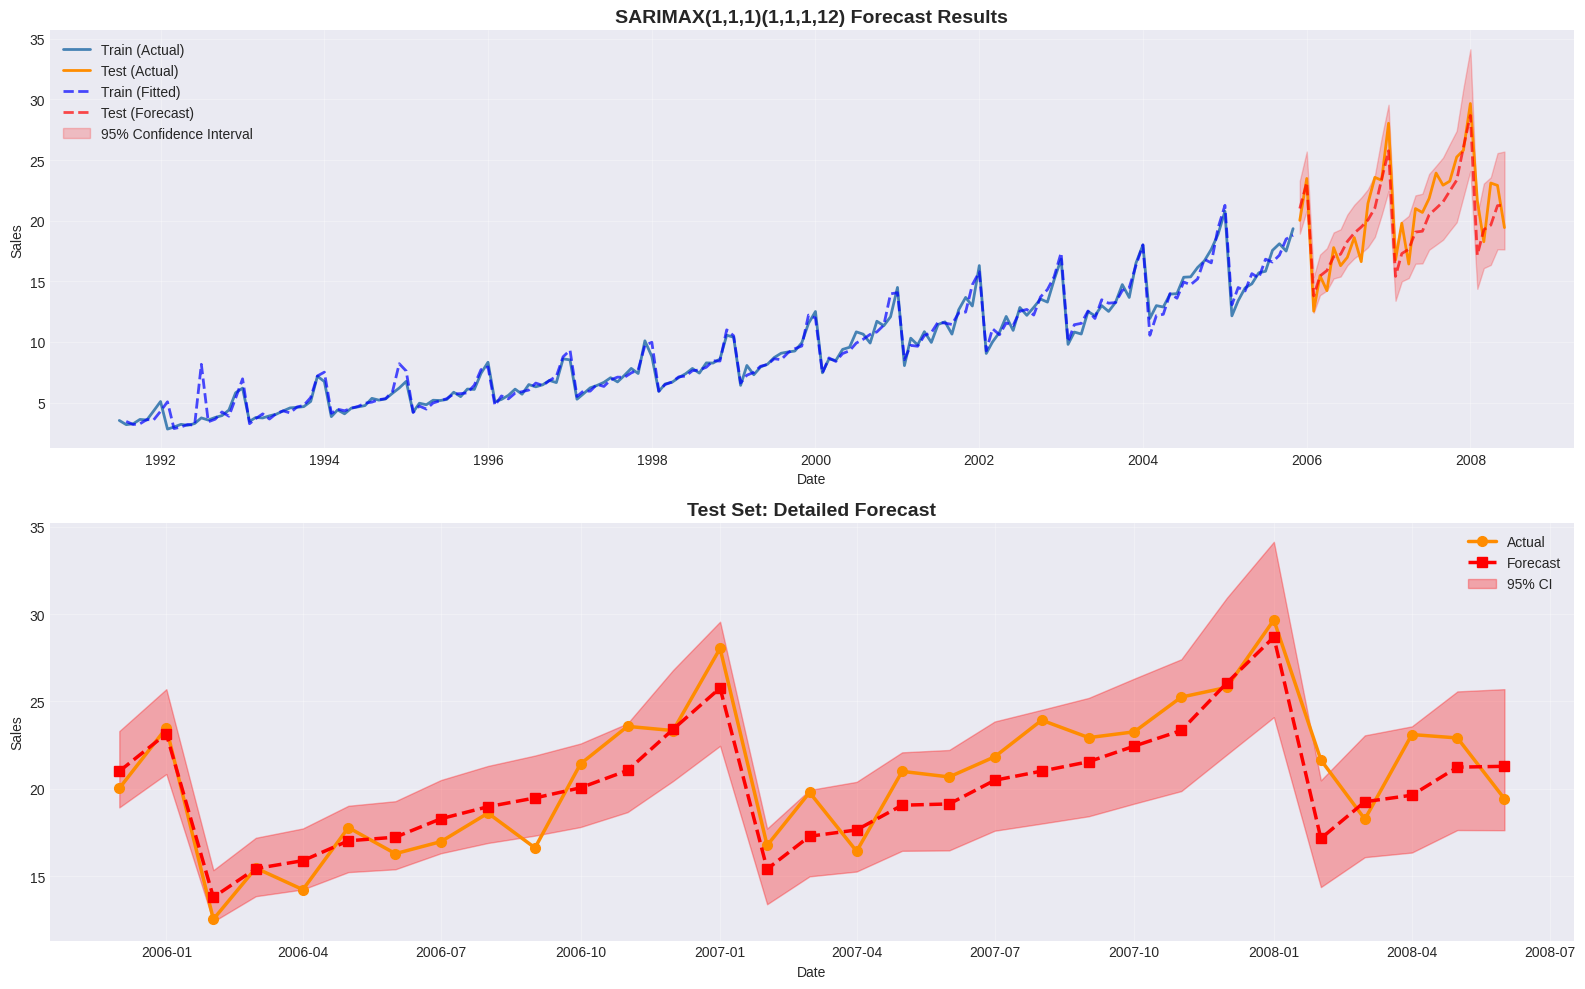

In [69]:
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Full forecast
axes[0].plot(train.index, train['sales'], label='Train (Actual)', linewidth=2, color='steelblue')
axes[0].plot(test.index, test['sales'], label='Test (Actual)', linewidth=2, color='darkorange')
axes[0].plot(train.index[1:], train_pred_original[1:], label='Train (Fitted)',
             linewidth=2, linestyle='--', alpha=0.7, color='blue')
axes[0].plot(test.index, forecast_original, label='Test (Forecast)',
             linewidth=2, linestyle='--', alpha=0.7, color='red')
axes[0].fill_between(test.index,
                      forecast_ci_original.iloc[:, 0],
                      forecast_ci_original.iloc[:, 1],
                      alpha=0.2, color='red', label='95% Confidence Interval')
axes[0].set_title('SARIMAX(1,1,1)(1,1,1,12) Forecast Results', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Sales')
axes[0].legend(loc='upper left')
axes[0].grid(True, alpha=0.3)

# Test set zoom
axes[1].plot(test.index, test['sales'], label='Actual',
             linewidth=2.5, marker='o', markersize=7, color='darkorange')
axes[1].plot(test.index, forecast_original, label='Forecast',
             linewidth=2.5, marker='s', markersize=7, linestyle='--', color='red')
axes[1].fill_between(test.index,
                      forecast_ci_original.iloc[:, 0],
                      forecast_ci_original.iloc[:, 1],
                      alpha=0.3, color='red', label='95% CI')
axes[1].set_title('Test Set: Detailed Forecast', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Sales')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. Grid Search로 최적 모델 찾기

In [70]:
import itertools
from tqdm import tqdm

# Define parameter ranges
p_range = range(0, 3)
d_range = range(0, 2)
q_range = range(0, 3)
P_range = range(0, 3)
D_range = range(0, 2)
Q_range = range(0, 3)
m = 12  # seasonal period

In [71]:
# Generate all combinations
pdq_combinations = list(itertools.product(p_range, d_range, q_range))
PDQ_combinations = list(itertools.product(P_range, D_range, Q_range))

# Remove (0,0,0) combinations
pdq_combinations = [x for x in pdq_combinations if sum(x) > 0]
PDQ_combinations = [x for x in PDQ_combinations if sum(x) > 0]

In [72]:
print(f"\nTesting {len(pdq_combinations)} x {len(PDQ_combinations)} = {len(pdq_combinations) * len(PDQ_combinations)} combinations...")


Testing 17 x 17 = 289 combinations...


In [73]:
# Grid search
results = []
best_aic = np.inf
best_params = None
best_seasonal_params = None
failed_count = 0

total_combinations = len(pdq_combinations) * len(PDQ_combinations)
print(f"\nStarting grid search (this may take a few minutes)...")
print(f"Total combinations to test: {total_combinations}\n")

# Create progress bar
pbar = tqdm(total=total_combinations, desc="Grid Search Progress",
            bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]')

for pdq in pdq_combinations:
    for PDQ in PDQ_combinations:
        try:
            model = SARIMAX(
                train['log_sales'],            # 종속변수 (예측할 시계열)
                order=pdq,                     # 비계절성 ARIMA 차수
                seasonal_order=PDQ + (m,),     # 계절성 ARIMA 차수
                enforce_stationarity=False,
                enforce_invertibility=False
            )

            fitted = model.fit(disp=False, maxiter=200)

            results.append({
                'order': pdq,
                'seasonal_order': PDQ + (m,),
                'AIC': fitted.aic,
                'BIC': fitted.bic,
                'HQIC': fitted.hqic
            })

            if fitted.aic < best_aic:
                best_aic = fitted.aic
                best_params = pdq
                best_seasonal_params = PDQ + (m,)
                best_model = fitted
                pbar.set_postfix({'Best AIC': f'{best_aic:.2f}',
                                 'Best Model': f'{best_params}x{best_seasonal_params}'})

        except Exception as e:
            failed_count += 1

        pbar.update(1)

pbar.close()


Starting grid search (this may take a few minutes)...
Total combinations to test: 289



Grid Search Progress: 100%|██████████| 289/289 [10:24<00:00]


In [74]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('AIC').reset_index(drop=True)

In [75]:
print("\n" + "="*50)
print("Top 10 Models by AIC")
print("="*50)
print(results_df.head(10).to_string(index=False))


Top 10 Models by AIC
    order seasonal_order         AIC         BIC        HQIC
(2, 0, 1)  (1, 0, 1, 12) -465.910111 -447.496686 -458.432615
(1, 1, 1)  (1, 0, 1, 12) -464.951774 -449.638799 -458.732982
(1, 0, 1)  (1, 0, 1, 12) -464.885919 -449.541398 -458.654672
(0, 1, 1)  (1, 0, 1, 12) -463.839868 -451.589488 -458.864835
(2, 1, 1)  (1, 0, 1, 12) -461.905678 -443.530107 -454.443127
(1, 0, 2)  (1, 0, 1, 12) -461.417128 -443.041558 -453.954577
(2, 1, 0)  (1, 0, 1, 12) -460.932685 -445.619710 -454.713893
(0, 1, 2)  (1, 0, 1, 12) -460.795876 -445.514647 -454.589633
(2, 0, 2)  (1, 0, 1, 12) -460.020335 -438.582169 -451.314026
(2, 1, 2)  (1, 0, 1, 12) -459.193082 -437.799362 -450.504342


In [76]:
# Best Model Found by Grid Search
print("\n" + "="*50)
print("Best Model Found by Grid Search")
print("="*50)
print(f"Order: {best_params}")
print(f"Seasonal Order: {best_seasonal_params}")
print(f"AIC: {best_aic:.2f}")
print("\n" + best_model.summary().as_text())


Best Model Found by Grid Search
Order: (2, 0, 1)
Seasonal Order: (1, 0, 1, 12)
AIC: -465.91

                                     SARIMAX Results                                      
Dep. Variable:                          log_sales   No. Observations:                  173
Model:             SARIMAX(2, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 238.955
Date:                            Sat, 11 Oct 2025   AIC                           -465.910
Time:                                    06:44:26   BIC                           -447.497
Sample:                                07-01-1991   HQIC                          -458.433
                                     - 11-01-2005                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.828

In [77]:
# Forecast with best model from grid search
grid_forecast = best_model.forecast(steps=len(test))
grid_forecast_original = np.exp(grid_forecast)

grid_test_mae = mean_absolute_error(test['sales'], grid_forecast_original)
grid_test_rmse = root_mean_squared_error(test['sales'], grid_forecast_original)
grid_test_mape = mean_absolute_percentage_error(test['sales'], grid_forecast_original)

print(f"\n[Grid Search Best Model - Test Set Performance]")
print(f"MAE:  {grid_test_mae:.2f}")
print(f"RMSE: {grid_test_rmse:.2f}")
print(f"MAPE: {grid_test_mape*100:.2f}%")


[Grid Search Best Model - Test Set Performance]
MAE:  1.82
RMSE: 2.12
MAPE: 8.64%


## 12. 모델 비교 시각화

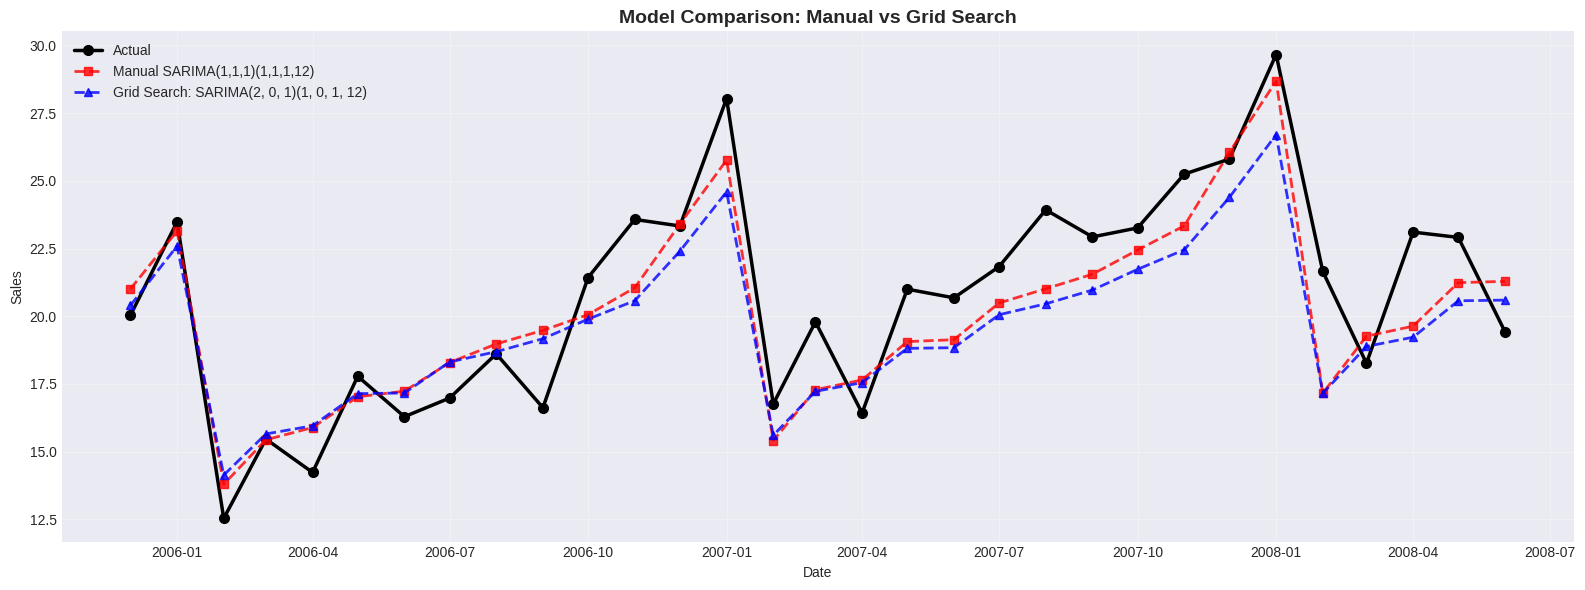

In [78]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(test.index, test['sales'], label='Actual',
        linewidth=2.5, marker='o', markersize=7, color='black')
ax.plot(test.index, forecast_original, label=f'Manual SARIMA(1,1,1)(1,1,1,12)',
        linewidth=2, marker='s', markersize=6, linestyle='--', color='red', alpha=0.8)
ax.plot(test.index, grid_forecast_original, label=f'Grid Search: SARIMA{best_params}{best_seasonal_params}',
        linewidth=2, marker='^', markersize=6, linestyle='--', color='blue', alpha=0.8)
ax.set_title('Model Comparison: Manual vs Grid Search', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

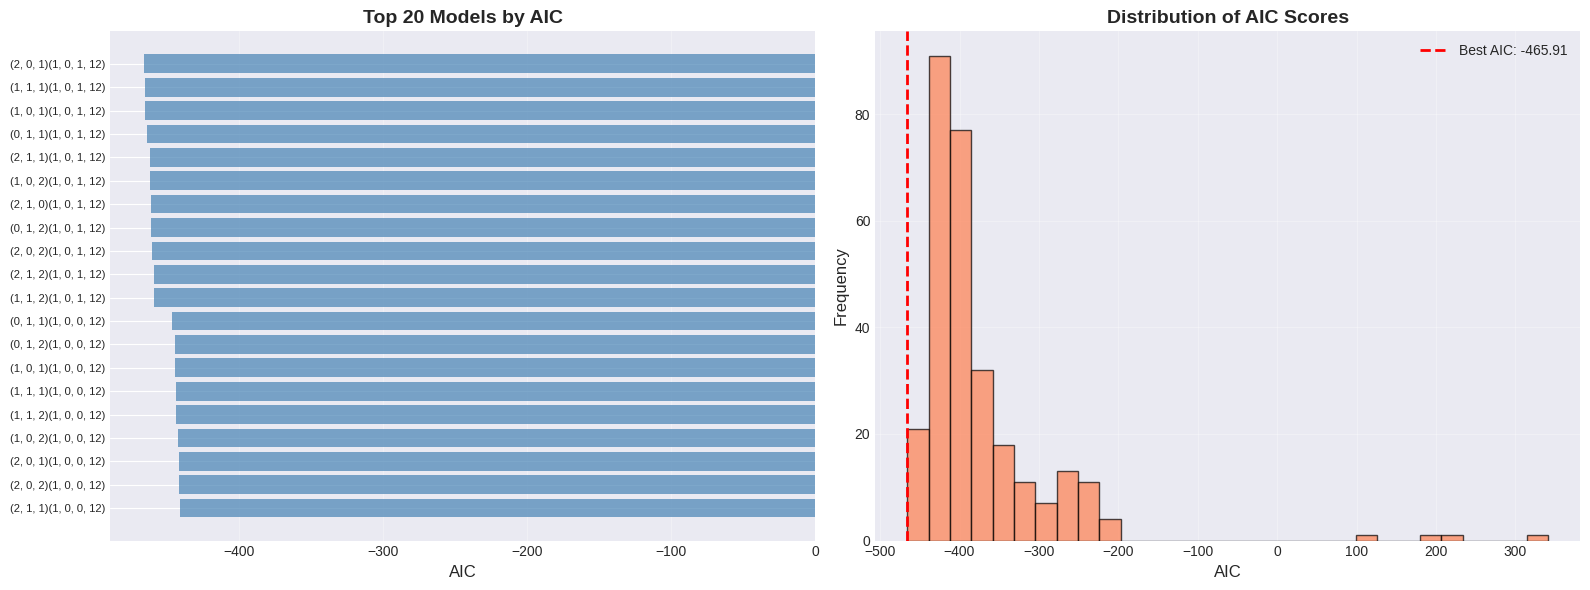

In [79]:
# Visualize AIC scores
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Top 20 models by AIC
top_models = results_df.head(20).copy()
top_models['model_name'] = top_models.apply(
    lambda x: f"{x['order']}{x['seasonal_order']}", axis=1
)

axes[0].barh(range(len(top_models)), top_models['AIC'], color='steelblue', alpha=0.7)
axes[0].set_yticks(range(len(top_models)))
axes[0].set_yticklabels(top_models['model_name'], fontsize=8)
axes[0].invert_yaxis()
axes[0].set_xlabel('AIC', fontsize=12)
axes[0].set_title('Top 20 Models by AIC', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='x')

# AIC distribution
axes[1].hist(results_df['AIC'], bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[1].axvline(best_aic, color='red', linestyle='--', linewidth=2, label=f'Best AIC: {best_aic:.2f}')
axes[1].set_xlabel('AIC', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of AIC Scores', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [80]:
# Model selection comparison
comparison_df = pd.DataFrame({
    'Model': ['Manual SARIMA', 'Grid Search Best'],
    'Specification': [
        'SARIMA(1,1,1)(1,1,1,12)',
        f'SARIMA{best_params}{best_seasonal_params}'
    ],
    'AIC': [fitted_model.aic, best_aic],
    'Test MAE': [test_mae, grid_test_mae],
    'Test RMSE': [test_rmse, grid_test_rmse],
    'Test MAPE': [f'{test_mape*100:.2f}%', f'{grid_test_mape*100:.2f}%']
})

print("\n" + "="*50)
print("Model Comparison Summary")
print("="*50)
print(comparison_df.to_string(index=False))


Model Comparison Summary
           Model                Specification         AIC  Test MAE  Test RMSE Test MAPE
   Manual SARIMA      SARIMA(1,1,1)(1,1,1,12) -423.840676  1.528136   1.822819     7.52%
Grid Search Best SARIMA(2, 0, 1)(1, 0, 1, 12) -465.910111  1.820566   2.123680     8.64%


Grid Search 모델의 문제:

- d=0, D=0: 차분을 하지 않음 → 비정상 시계열을 그대로 모델링
- p=2: 대신 AR(2)로 트렌드를 흡수하려 함
- Train 데이터에서는 잘 맞을 수 있지만 (낮은 AIC)
- 외삽(extrapolation)에 취약 → Test 성능 하락

Manual 모델의 강점:

- d=1, D=1: 트렌드와 계절성을 제거 → 정상 시계열
- 정상 시계열은 예측에 더 안정적
- Train AIC는 높아도 일반화 성능이 좋음

